# 상점 신용카드 매출 예측하기

2016.06.01 ~ 2019.02.28 까지의 신용카드 매출 데이터를 가지고  
    2019.03.01 ~ 2019.05.31 까지의 상점별 3개월 총 매출을 예측하기

- 전통적인 금융권은 소상공인 대출 시 신용점수 또는 담보물 위주의 평가를 진행
- 한국의 핀테크 기업인 'FUNDA(펀다)'는 상환 기간의 매출을 예측해  
    신용 점수가 낮거나 담보가 없는 우수 상점에 금융 기회를 제공하려고 함
- 대출 상점 총 매출 예측 경진대회는 상환기간의 '총매출'을 예측하는 모델을 만드는 것
- 펀다에서는 예측된 매출을 기반으로 대출 한도를 설정함
- 모델이 정확할수록 더 낮은 금리와 더 높은 한도를 제공함

### 경진대회 개요

주최자 | 펀다, 데이콘
:-----|:-----
총 상금 | 100만원 
문제 유형 | 시계열 회귀 분석 (Time Series Regression Analysis)
평가 척도 | MAE
대회 기간 | 2019년 7월 11일 ~ 2019년 8월 31일
대회 참여팀 | 292팀

## 1. 데이터 살펴보기

In [1]:
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

# 데이터 읽어오기
train = pd.read_csv('./funda_train.csv')
submission = pd.read_csv('./submission.csv')

In [2]:
train.shape

(6556613, 9)

In [3]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [4]:
train.tail()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
6556608,2136,4663855,d,2019-02-28,23:20,0,제주 제주시,기타 주점업,-4500.000000
6556609,2136,4663855,d,2019-02-28,23:24,0,제주 제주시,기타 주점업,4142.857143
6556610,2136,4663489,a,2019-02-28,23:24,0,제주 제주시,기타 주점업,4500.000000
6556611,2136,4663856,d,2019-02-28,23:27,0,제주 제주시,기타 주점업,571.428571
6556612,2136,4658616,c,2019-02-28,23:54,0,제주 제주시,기타 주점업,5857.142857


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


#### 컬럼설명  
1. store_id (int64) : 상점의 고유 아이디   
2. card_id (int64) : 사용한 카드의 고유 아이디  
3. card_company (object) : 비식별화된 카드 회사  
4. transacted_date (object) : 거래날짜  
5. transacted_time (object) : 거래시간(시:분)  
6. installment_term (int64) : 할부개월수(포인트 사용 시 '60개월+실제할부개월'을 할부개월수에 기재함)  
7. region (object) : 상점의 지역  
8. type_of_business (object): 상점의 업종  
9. amount (float64): 매출액(단위는 원이 아님)

In [6]:
train.describe()

,store_id,card_id,installment_term,amount
count,6.556613e+06,6.556613e+06,6.556613e+06,6.556613e+06
mean,1.084930e+03,2.268127e+06,1.382017e-01,1.043511e+04
std,6.152183e+02,1.351058e+06,1.188152e+00,3.104031e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.771429e+06
25%,5.860000e+02,1.088828e+06,0.000000e+00,2.142857e+03
50%,1.074000e+03,2.239304e+06,0.000000e+00,4.285714e+03
75%,1.615000e+03,3.438488e+06,0.000000e+00,8.571429e+03
max,2.136000e+03,4.663856e+06,9.300000e+01,5.571429e+06


In [7]:
train.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

region과 type_of_business에 결측치가 있다는 것을 알 수 있다.

In [8]:
train['region'].value_counts()

경기 수원시    122029
충북 청주시    116766
경남 창원시    107147
경남 김해시    100673
경기 평택시     82138
           ...  
경남 거창군      1143
서울 관악구      1037
경남 함안군       878
경북 영천시       849
전남 완도군       681
Name: region, Length: 180, dtype: int64

region의 value는 180가지

In [9]:
train['type_of_business'].value_counts()

한식 음식점업                     745905
두발 미용업                      178475
의복 소매업                      158234
기타 주점업                      102413
치킨 전문점                       89277
                             ...  
곡물 및 기타 식량작물 재배업               569
주방용품 및 가정용 유리, 요업 제품 소매업       551
배전반 및 전기 자동제어반 제조업             533
그 외 기타 생활용품 도매업                519
신선식품 및 단순 가공식품 도매업             231
Name: type_of_business, Length: 145, dtype: int64

type_of_business의 value는 145가지

In [10]:
train['store_id'].value_counts()

1330    9518
1196    9471
1171    9391
710     9347
826     9328
        ... 
1974     429
1240     426
795      231
2119     112
1063      72
Name: store_id, Length: 1967, dtype: int64

상점의 갯수는 1,967개

In [11]:
train[train['amount']<0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857
...,...,...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,제주 제주시,기타 주점업,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,제주 제주시,기타 주점업,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,제주 제주시,기타 주점업,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,제주 제주시,기타 주점업,-8571.428571


amounts 값 중 음수가 있음을 확인 -> 이상치

## 2. 데이터 전처리

### 2-1. 노이즈 제거

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# 데이터 읽어오기
train = pd.read_csv('./funda_train.csv')
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


#### 데이터 결측치 확인

In [13]:
train.isnull().sum()

store_id                  0
card_id                   0
card_company              0
transacted_date           0
transacted_time           0
installment_term          0
region              2042766
type_of_business    3952609
amount                    0
dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

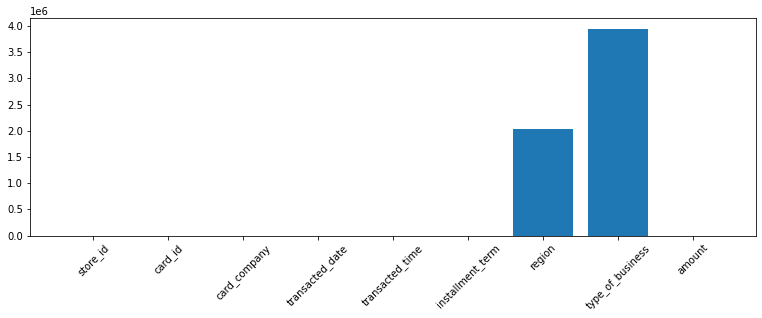

In [14]:
plt.figure(figsize=(13, 4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)  # x축 레이블 텍스트 회전 (45도만큼 회전)

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
store_id            int64
card_id             int64
card_company        object
transacted_date     object
transacted_time     object
installment_term    int64
region              object
type_of_business    object
amount              float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


결측치가 포함된 열(region, type_of_business)의 dtype은 object로,  
범주형 속성이고 대치할 방법이 없기때문에 열 전체를 제거하고 결과를 출력 해 보았다.

In [16]:
train = train.drop(['region','type_of_business'],axis=1) # axis=1 : 열 방향으로 동작
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


#### 매출액(amount) 변수에 대한 이상치 존재 확인

<AxesSubplot:xlabel='amount'>

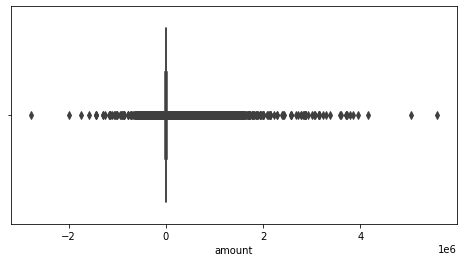

In [17]:
plt.figure(figsize=(8,4))
sns.boxplot(train['amount'])

amount(매출액) 값으로 음수가 존재하는 것을 확인할 수 있다 -> 이상치  
환불 건으로 예측이 되므로, 환불 발생현황을 확인하기 위해 매출액이 0 미만인 행을 출력 해 보자.

In [18]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


In [19]:
train[train['amount']<0].count()

store_id            73100
card_id             73100
card_company        73100
transacted_date     73100
transacted_time     73100
installment_term    73100
amount              73100
dtype: int64

#### 시계열 데이터 처리를 하기 위해
dtype이 object였던 transacted_date와 transacted_time을  
datetime이라는 하나의 칼럼으로 합치고, dtype을 datetime으로 변환

In [20]:
# 거래일과 거래시간을 합친 변수를 생성
train['datetime'] = pd.to_datetime(train.transacted_date + " " + 
                                train.transacted_time, format='%Y-%m-%d %H:%M:%S')

In [21]:
train['datetime'].head()

0   2016-06-01 13:13:00
1   2016-06-01 18:12:00
2   2016-06-01 18:52:00
3   2016-06-01 20:22:00
4   2016-06-02 11:06:00
Name: datetime, dtype: datetime64[ns]

#### 환불 거래건 제거하기

1. amount가 음수로 발생(환불 발생)한 시간 이전의 거래내역 중 음수 매출액(환불금액)의 절댓값과 같은 행 제거  
    -> 음수 매출액의 행만 제거하면, 환불하기 전의 양수 매출액이 매출액 집계 시 과대 계상되기 때문.  <br><br>
    
2. 환불 발생일(transacted_date)과 환불 발생시간(transacted_time) 이전 데이터 中 card_id가 같고,  
    음수 매출액(amount)의 절댓값 == 양수 매출액(amount)인 최근 거래를 찾아서 해당 인덱스 제거  

In [22]:
# 환불 거래를 제거하는 함수 정의

def remove_refund(df): # df 를 변수로 받음
    
    # 환불 거래 (매출액<0)
    refund = df[df['amount']<0] 
    
    # 구입 거래 (매출액>0)
    non_refund = df[df['amount']>0]
    
    # 환불 거래 제거한 거래 건
    removed_data = pd.DataFrame()
    
    for i in tqdm(df.store_id.unique()): # 반복문이 어디까지 진행됐는지 표시
        
        # 매출액이 양숫값인 데이터를 상점별로 나누기
        divided_data = non_refund[non_refund['store_id']==i] 
        
        # 매출액이 음숫값인 데이터를 상점별로 나누기
        divided_data2 = refund[refund['store_id']==i]

        for neg in divided_data2.to_records()[:]: # 환불 데이터를 차례대로 검사
            # .to_records() -> rec.array([('인덱스a', value1a, value2a,...), ('인덱스b', value1a, value2a,...)...])
            
            refund_store = neg['store_id']
            refund_id = neg['card_id'] # 환불 카드 아이디 추출
            refund_datetime = neg['datetime'] # 환불 시간 추출
            refund_amount = abs(neg['amount']) # 매출 음숫값의 절댓값 구하기
            
            # 환불 시간 이전의 데이터 중 
            refund_pay_list = divided_data[divided_data['datetime']<=refund_datetime]
            # 카드 아이디가 같고
            refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]
            # 환불액이 같은 후보 리스트를 뽑는다.
            refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount]
            
            # 후보 리스트가 있다면 -> 카드 아이디, 환불액이 같으면서 가장 최근시간을 제거
            if(len(refund_pay_list)!=0):
                refund_datetime = max(refund_pay_list['datetime']) # 가장 최근 시간 구하기
                
                noise_list = divided_data[divided_data['datetime']==refund_datetime] # 가장 최근시간
                noise_list = noise_list[noise_list['card_id']==refund_id] # 환불 카드 아이디
                noise_list = noise_list[noise_list['amount']==refund_amount] # 환불금액
                
                divided_data = divided_data.drop(index=noise_list.index) # 인덱스를 통해 제거
                
                
        # 제거한 데이터를 데이터프레임에 추가
        removed_data = pd.concat([removed_data,divided_data],axis=0)
    
    return removed_data

#### 환불 거래 건 삭제한 데이터를 boxplot으로 확인 해 보기

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [14:58<00:00,  2.19it/s]


<AxesSubplot:xlabel='amount'>

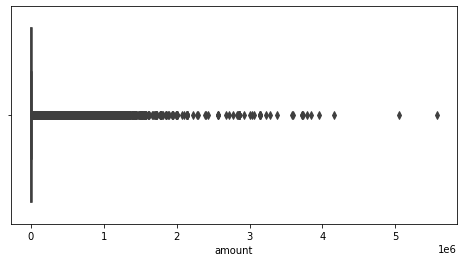

In [23]:
# 환불 거래 건 삭제하는 함수(remove_refund())실행
positive_data = remove_refund(train)

# 환불 거래 삭제된 데이터를 boxplot으로 확인 (amout 기준)
plt.figure(figsize=(8,4))
sns.boxplot(positive_data['amount'])

In [24]:
positive_data[positive_data['amount']<0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime


In [25]:
positive_data[positive_data['amount']>0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...
6556606,2136,4663854,f,2019-02-28,23:03,0,3928.571429,2019-02-28 23:03:00
6556609,2136,4663855,d,2019-02-28,23:24,0,4142.857143,2019-02-28 23:24:00
6556610,2136,4663489,a,2019-02-28,23:24,0,4500.000000,2019-02-28 23:24:00
6556611,2136,4663856,d,2019-02-28,23:27,0,571.428571,2019-02-28 23:27:00


### 2-2. Down Sampling

시계열 데이터에서 '시간 간격을 넓게 재조정'해 데이터 샘플수를 줄이는 것  
시계열 모델을 만들 때, 시간 간격을 좁게 하면 예측해야 하는 구간이 커져서 불확실성이 증가하기 때문에,  
Down Sampling을 통해 샘플 수를 줄이고 예측 구간을 작게 해서 불확실성을 줄인다.

In [26]:
# 환불 거래 건 삭제했던 데이터프레임(positive_data)
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [27]:
# 분 단위의 시간간격을 월 단위로 down sampling 하는 함수 정의
def month_resampling(df):
    new_data = pd.DataFrame()
    
    # year-month 까지만 표시하는 변수 생성
    df['year_month'] = df['transacted_date'].str.slice(stop=7)
    
    # 데이터의 전체 기간을 추출
    # .drop_duplicates() -> 중복값 처리.unique한 1개의 key만 남기고 나머지 중복값 제거
    year_month = df['year_month'].drop_duplicates()
    
    # 상점 아이디별로 월 단위 매출액 총합 구하기
    # .groupby() : 지정한 열이 같은 항목끼리 gouping !
    downsampling_data = df.groupby(['store_id', 'year_month']).amount.sum()
    downsampling_data = pd.DataFrame(downsampling_data)
    downsampling_data = downsampling_data.reset_index(drop=False,inplace=False)
    
    
    for i in tqdm(df.store_id.unique()): # 반복문이 어디까지 진행됐는지 표시
        # 상점별로 데이터를 처리
        store = downsampling_data[downsampling_data['store_id']==i]

        # 각 상점의 처음 매출이 발생한 월을 구합니다.
        start_time = min(store['year_month'])

        # 모든 상점을 전체 기간 데이터로 만들어주기
        store = store.merge(year_month,how='outer')

        # 데이터를 시간순으로 정렬합니다.
        store = store.sort_values(by=['year_month'], axis=0, ascending=True) 
        
        # 매출이 발생하지 않는 월은 2로 채우기
        # 나중에 시계열 데이터의 진동폭을 안정화하기 위해 '로그정규화'를 할건데
        # 1 이하의 값은 로그 정규화를 할때 음수or무한대가 나오기 때문
        store['amount'] = store['amount'].fillna(2) 

        # 상점 아이디 결측치 채우기
        store['store_id'] = store['store_id'].fillna(i)  

        # 처음 매출이 발생한 월 이후만 뽑기
        store = store[store['year_month']>=start_time] 

        new_data = pd.concat([new_data,store],axis=0)
        
    return new_data

In [28]:
# 환불 거래를 제거한 데이터(positive_data)를 월 단위로 Down Sampling
resampling_data = month_resampling(positive_data)
print(resampling_data['store_id'].dtypes)

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:14<00:00, 133.59it/s]

float64


In [29]:
# sampling_data['store_id'] 형변환 ( float64 -> int)
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.697143e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.012214e+06
18,2136,2018-11,2.127643e+06
19,2136,2018-12,2.427429e+06
20,2136,2019-01,1.867786e+06


이렇게 월 단위의 데이터로 down sampling을 했기 때문에,  
미래 3개월의 매출을 예측하기 위한 예측 구간이  
(3개월 * 30일 * 24시간 * 60분)개 -> (3개월)개 로 줄어들었다.  
129,600개 -> 3개

Down Sampling은 예측구간을 최소화시켜 불확실성을 줄여주지만,  
시간 간격을 너무 크게 재조정하면 작은 데이터 샘플로 인해 오히려 정확도가 떨어진다.<br><br>
-> 따라서 지속적인 탐색을 통해 적절한 Down Sampling 시간 간격을 찾는 것이 주요 과제이다.

### 2-3. 날짜  지정 범위 생성과 시리즈 객체 변환

In [30]:
# DownSampling까지 완료한 데이터의 타입 확인 -> DataFrame
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


시계열 분석을 위해, 상점 아이디별로 인덱스에 날짜 지정범위를 생성 & 시리즈 객체로 변환

In [31]:
# DataFrame -> Series 변환하는 함수
# 함수의 인자 -> df: DownSampling한 데이터, i: 상점아이디
def time_series(df, i):
    
    # 상점별로 데이터 추출
    store = df[df['store_id']==i]
    
    # 날짜 지정 범위: 영업 시작 월부터 2019년 3월 전까지 영업 마감일 기준
    ## .date_range(): 시간 변수의 날짜 지정범위 생성
    ## freq: 빈도를 나타내는 매개변수(파라미터). 
    ## freq='BM' -> business month end frequency, 매월 마지막 영업일
    index = pd.date_range(min(store['year_month']),'2019-03',freq='BM') 
    
    # 시리즈 객체로 변환
    ## value(값): 매출액 , 인덱스: 첫 영업월부터 2019년 3월까지의 매월 마지막 영업일
    ts = pd.Series(store['amount'].values,index=index)
    
    return ts

In [32]:
# time_series 함수 실행 테스트
# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.697143e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.970000e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.282857e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.798571e+05
2018-09-28    6.518571e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

In [33]:
# 상점 아이디가 1번인 데이터를 시리즈 객체로 변환
store_1 = time_series(resampling_data, 1)

# 데이터 타입 확인
print(type(store_1))

<class 'pandas.core.series.Series'>


데이터타입이 DataFrame -> Series로 잘 변환된 것을 확인할 수 있다.

<AxesSubplot:>

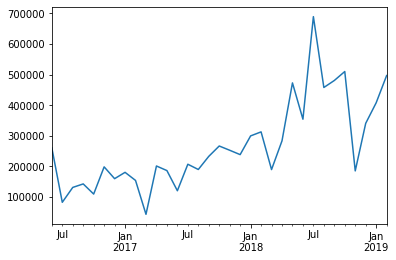

In [34]:
# 상점 아이디가 2번인 데이터를 시리즈 객체로 변환
store_2 = time_series(resampling_data, 2)

# 시계열 그래프 그리기
store_2.plot()

## 3. EDA (탐색적 데이터 분석)

### 3-1. 상점별 매출 특성 분석

<b>[상점의 특징]<br></b>
    1. 계절성이 있는 상점  
    2. 추세가 있는 상점  
    3. 휴업 중인 상점  

#### 계절성이 있는 상점

In [35]:
train[train['store_id']==257]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
754179,257,502225,f,2016-06-04,15:53,0,7857.142857,2016-06-04 15:53:00
754180,257,502226,f,2016-06-04,16:59,0,23571.428571,2016-06-04 16:59:00
754181,257,502227,g,2016-06-06,10:08,0,6285.714286,2016-06-06 10:08:00
754182,257,502227,g,2016-06-06,14:02,0,3142.857143,2016-06-06 14:02:00
754183,257,502228,e,2016-06-06,17:58,0,6285.714286,2016-06-06 17:58:00
...,...,...,...,...,...,...,...,...
754882,257,502574,c,2018-09-12,14:02,0,142.857143,2018-09-12 14:02:00
754883,257,502726,e,2018-09-12,14:03,0,38571.428571,2018-09-12 14:03:00
754884,257,502727,h,2018-09-14,17:03,0,71342.857143,2018-09-14 17:03:00
754885,257,502728,e,2018-09-17,18:13,0,31428.571429,2018-09-17 18:13:00


##### 대표적인 계절성 특징의 예 > 257번 상점

In [36]:
# store_id가 257번인 데이터를 시리즈 객체로 데이터 출력
store_257 = time_series(resampling_data, 257)
store_257

2016-06-30    4.891857e+05
2016-07-29    1.595280e+06
2016-08-31    1.518714e+06
2016-09-30    3.369143e+05
2016-10-31    4.245714e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.928571e+04
2017-05-31    1.557286e+05
2017-06-30    5.481143e+05
2017-07-31    7.359286e+05
2017-08-31    7.909700e+05
2017-09-29    6.191429e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.493857e+05
2018-06-29    4.822286e+05
2018-07-31    8.999714e+05
2018-08-31    1.645877e+06
2018-09-28    2.767857e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

데이터 전처리 과정에서 매출이 발생하지 않았던 월의 매출을 2로 대체했기 때문에  
257번 상점은 11월~3월 동안 매출이 발생하지 않는다는 것을 알 수 있다.

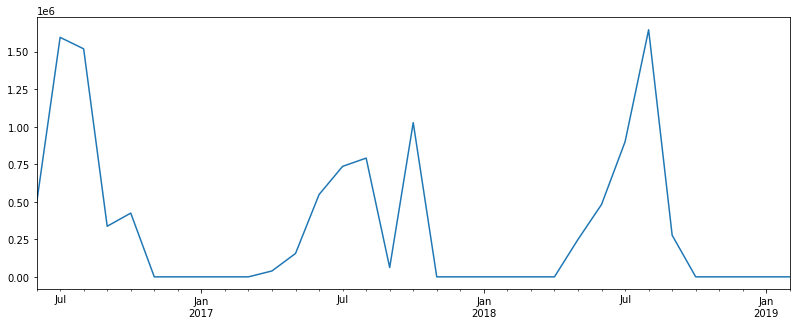

In [37]:
# 시계열 그래프 그리기
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5,5)

-> 3월~5월에는 많은 매출액이 발생하지 않을 것이라는 것을 시계열 그래프를 통해 직관적으로 알 수 있음. 

In [38]:
# store_id가 2096번인 데이터를 시리즈 객체로 데이터 출력
store_2096 = time_series(resampling_data, 2096)
store_2096

2016-07-29    5.075429e+04
2016-08-31    9.219543e+05
2016-09-30    4.720786e+05
2016-10-31    5.145714e+05
2016-11-30    1.494286e+05
2016-12-30    1.071686e+06
2017-01-31    1.602857e+06
2017-02-28    1.332143e+06
2017-03-31    2.432143e+05
2017-04-28    3.903143e+06
2017-05-31    1.729500e+06
2017-06-30    4.280214e+06
2017-07-31    1.775714e+06
2017-08-31    7.428571e+05
2017-09-29    1.415714e+06
2017-10-31    1.180714e+06
2017-11-30    4.640000e+05
2017-12-29    1.389729e+06
2018-01-31    2.000000e+00
2018-02-28    8.285714e+05
2018-03-30    7.857143e+05
2018-04-30    6.670429e+06
2018-05-31    1.837286e+05
2018-06-29    3.285714e+06
2018-07-31    9.502857e+05
2018-08-31    3.675200e+06
2018-09-28    1.793886e+06
2018-10-31    4.717743e+06
2018-11-30    7.593600e+06
2018-12-31    1.428571e+06
2019-01-31    4.285714e+05
2019-02-28    1.428571e+06
Freq: BM, dtype: float64

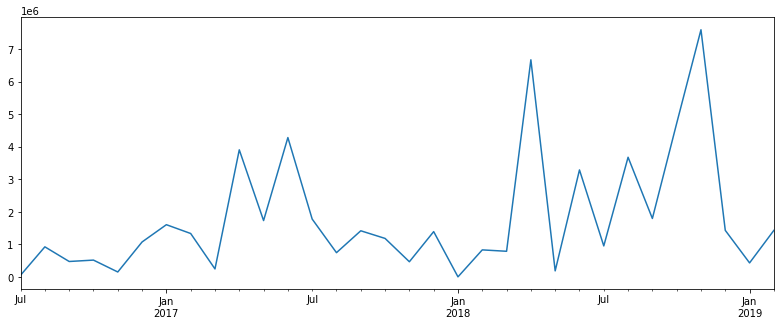

In [39]:
# 시계열 그래프 그리기
store_plot_2096 = store_2096.plot()
fig = store_plot_2096.get_figure()
fig.set_size_inches(13.5,5)

store_id가 2096번인 상점  
-> 3월~5월에는 많은 매출액이 급 상승할 것이라는 것을 시계열 그래프를 통해 직관적으로 알 수 있음.

#### 추세가 있는 상점

매출액이 꾸준히 증가하거나 꾸준히 감소하는 상점.  

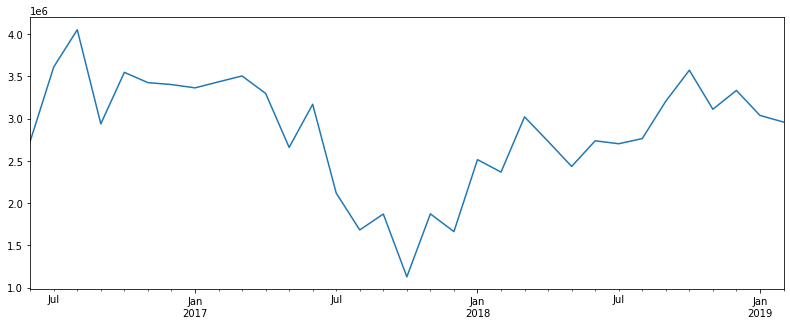

In [40]:
# store_id가 335인 상점의 시계열 그래프
store_335 = time_series(resampling_data, 335)

store_plot_335 = store_335.plot()
fig = store_plot_335.get_figure()
fig.set_size_inches(13.5,5)

매출액 증감 등의 변동은 매월 있음을 시계열 그래프를 통해 확인 할 수 있다.  
월단위의 작은 변동 보다는, 기간을 1년 단위로 늘려서 추세를 파악할 필요가 있다.  
데이터 전체의 기간을 절반으로 나누면,  
2016.06 ~ 2017.10 -> 매출액 감소추세<br>
2017.11 ~ 2019.02 -> 매출액 증가추세<br><br>

따라서 2019.03~2019.05의 매출을 예측할 때에는  
증가 추세임을 고려해야 한다는 것을 알 수 있다.  

##### 매출액 감소추세의 예 >  510번 상점

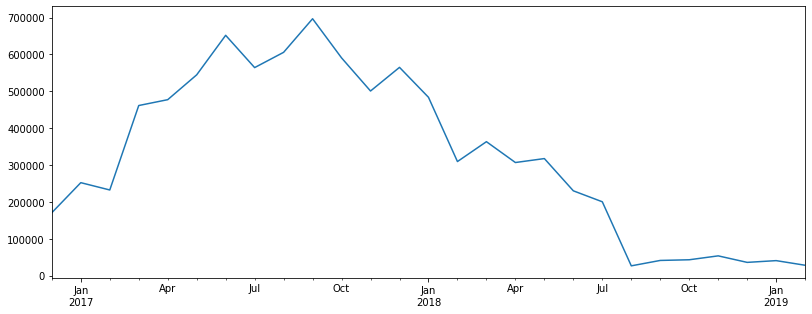

In [41]:
# store_id가 510인 상점의 시계열 그래프
store_510 = time_series(resampling_data, 510)
store_plot_510 = store_510.plot()
fig = store_plot_510.get_figure()
fig.set_size_inches(13.5,5)

#### 휴업 중인 상점

##### 대표적인 휴업 특징의 예 > 111번 상점

In [42]:
# 상점 아이디가 111번인 데이터를 시리즈 객체로 데이터 출력
store_111 = time_series(resampling_data, 111)
store_111

2016-06-30    812428.571429
2016-07-29    391142.857143
2016-08-31     13071.428571
2016-09-30    495714.285714
2016-10-31    182714.285714
2016-11-30    178571.428571
2016-12-30     43005.714286
2017-01-31         2.000000
2017-02-28      5428.571429
2017-03-31     24857.142857
2017-04-28    108000.000000
2017-05-31    459142.857143
2017-06-30    137571.428571
2017-07-31    216285.714286
2017-08-31     77000.000000
2017-09-29     78005.714286
2017-10-31         2.000000
2017-11-30         2.000000
2017-12-29         2.000000
2018-01-31      1428.571429
2018-02-28    309785.714286
2018-03-30    259071.428571
2018-04-30    225858.571429
2018-05-31    105571.428571
2018-06-29         2.000000
2018-07-31    123285.714286
2018-08-31         2.000000
2018-09-28     83000.000000
2018-10-31         2.000000
2018-11-30         2.000000
2018-12-31         2.000000
2019-01-31         2.000000
2019-02-28         2.000000
Freq: BM, dtype: float64

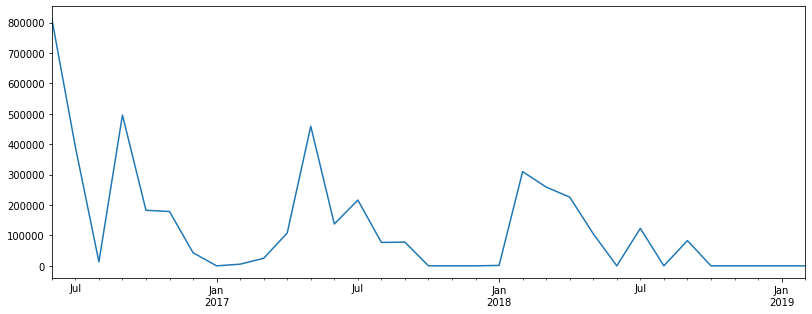

In [43]:
# 상점 아이디가 111번인 상점의 시계열 그래프
store_plot_111 = store_111.plot()
fig = store_plot_111.get_figure()
fig.set_size_inches(13.5,5)

-> 직관적으로 2019년 3월 ~ 2019년 5월에는 매출이 발생하지 않을 것으로 예측할 수 있음

##### 장기휴업 후 영업재개한 상점의 예 > 279번 상점

In [44]:
# 상점 아이디가 279번인 데이터를 시리즈 객체로 데이터 출력
store_279 = time_series(resampling_data, 279)
store_279

2016-06-30    4.488571e+05
2016-07-29    1.156286e+06
2016-08-31    1.372857e+06
2016-09-30    3.150000e+05
2016-10-31    8.748571e+05
2016-11-30    3.128571e+05
2016-12-30    5.828571e+05
2017-01-31    3.214286e+04
2017-02-28    2.000000e+00
2017-03-31    4.955714e+05
2017-04-28    5.940000e+05
2017-05-31    1.041143e+06
2017-06-30    8.354286e+05
2017-07-31    6.171429e+05
2017-08-31    4.284286e+05
2017-09-29    1.581258e+06
2017-10-31    3.294286e+05
2017-11-30    2.241429e+05
2017-12-29    2.785714e+05
2018-01-31    4.018571e+05
2018-02-28    1.282857e+05
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.000000e+00
2018-06-29    2.000000e+00
2018-07-31    2.000000e+00
2018-08-31    2.000000e+00
2018-09-28    2.000000e+00
2018-10-31    2.000000e+00
2018-11-30    2.101429e+05
2018-12-31    2.191571e+05
2019-01-31    1.779286e+05
2019-02-28    5.157143e+04
Freq: BM, dtype: float64

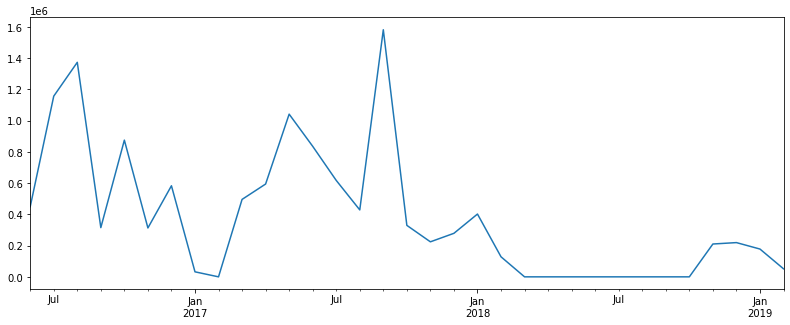

In [45]:
# 상점 아이디가 279번인 상점의 시계열 그래프
store_plot_279 = store_279.plot()
fig = store_plot_279.get_figure()
fig.set_size_inches(13.5,5)

-> 2019년 3월 ~ 2019년 5월에는 휴업이 예상됨

### 3-2. 시계열 데이터의 정상성

<b>[정상성]
* 추세나 계절성이 없는 시계열 데이터  
* 데이터가 시간의 변동에 따라 평균과 분산이 일정함.  
* 시간이 변해도 일정한 분포를 따름 
* 시계열 분석을 하기 위해서 정상성을 만족해야 한다. <br><br>
  
1. ADF-Test 사용하여 정상성 판단
2. 차분을 통해 비정상 시계열 -> 정상 시계열로 변환

#### ADF-TEST

<b> Augmented Dickey-Fuller-Test  
* 시계열 데이터가 정상성을 가지는지 판단할 때 사용
* 회귀분석 결과로 나온 계수를 검정 통계량으로 사용
* ADF-Test를 통해 시계열 데이터가 정상성을 가지는지 검정하고,  
  정상성을 가지지 않으면 차분을 통해 평균을 일정하게 만들어 줘야 함.
* 차분: 비정상 시계열을 평균이 일정한 정상 시계열로 바꾸는 기법.

##### 정상 시계열의 예 > 0번 상점

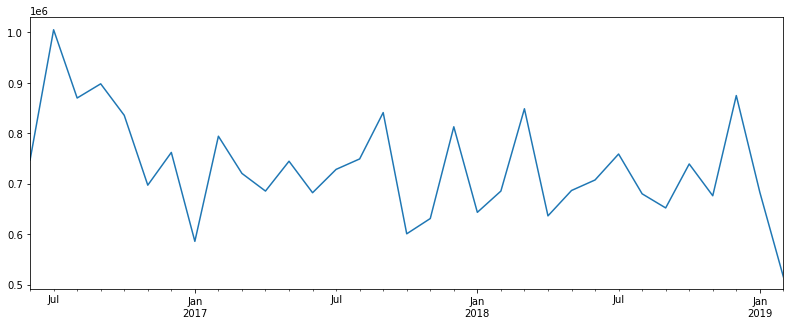

In [46]:
# 상점 아이디가 0번인 상점의 시계열 그래프
store_0 = time_series(resampling_data, 0)
store_plot_0 = store_0.plot()
fig = store_plot_0.get_figure()
fig.set_size_inches(13.5,5)

-> 매출액 시계열의 평균과 분산이 일정함.

##### 비정상 시계열의 예 > 257번 상점(계절성 有)

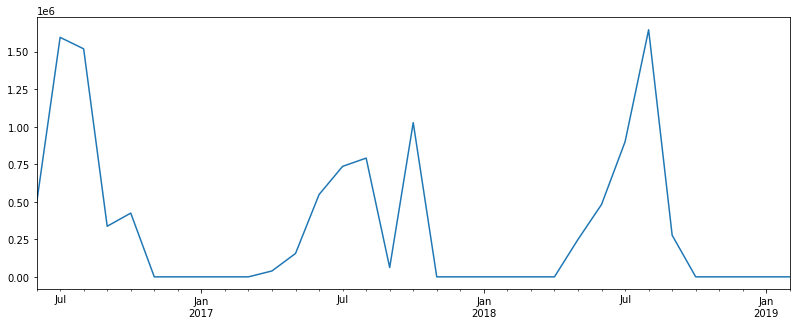

In [47]:
# 상점 아이디가 257번인 상점의 시계열 그래프
store_257 = time_series(resampling_data, 257)
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5,5)

-> 매출액 시계열이 계절성을 띠고, 평균과 분산의 변동 폭이 큼

#### ADF-Test를 통해 0번 상점과 257번 상점이 정상 시계열인지 확인 해보기

ADF-Test는 통계학에서 시행하는 가설 검정의 절차를 따른다.<br><br>
<가설설정><br>
귀무가설($H_{0}$) : 시계열 자료가 정상 시계열이 아니다.<br>
대립가설($H_{1}$) : 시계열 자료가 정상성을 만족한다.

#### pmdarima 패키지에 있는 ADF-Test 클래스를 임포트해 가설 검정을 시행하는 코드

In [48]:
# pmdarima 패키지에 있는 ADFTest 클래스를 임포트
from pmdarima.arima import ADFTest

# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)

# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_0)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.022488 , should_diff : False


-> p_val < 0.05이므로, $H_{0}$ 기각(정상성을 만족함) & 차분 불필요

In [49]:
# 상점 아이디가 257번인 데이터를 시리즈 객체로 변환
store_257 = time_series(resampling_data, 257)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_257)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : 0.093614 , should_diff : True


-> p_val > 0.05이므로, $H_{0}$ 채택(정상 시계열이 아님) & 차분 필요 !

* <b> 이런 식으로 1,967개의 상점을 개별적으로 가설검정을 하면 비효율적<br>
    -> 1,967개 상점의 ADF-Test의 p-value값을 파이썬의 리스트 자료형에 저장 & boxplot으로 p-value값의 분포 확인<br><br>
* p-value < 0.05 인 상점개수 계산<br><br>              
* 매출이 수개월간 발생하지 않는 상점은 ADF-Test 오류 발생하기때문에, 예외처리 진행 (ex> 795번 상점)

100%|█████████████████████████████████████████████████████████████████████████████| 1967/1967 [00:07<00:00, 259.60it/s]


<AxesSubplot:>

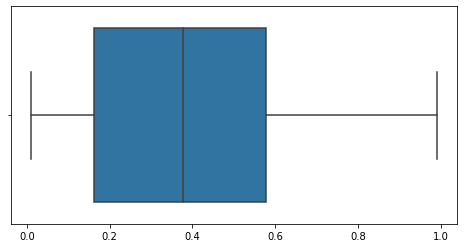

In [50]:
# ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
    return ADFTest().should_diff(y)[0]

# 전체 상점 adf_test p-value 값을 리스트에 저장 & boxplot 그리기
adf_p = []
count = 0
skipped = []

for i in tqdm(resampling_data['store_id'].unique()):
    # store_id가 i인 상점의 데이터를 시리즈 객체로 변환해서 ts로 저장
    ts = time_series(resampling_data,i)
    
    # 예외처리
    # p-value < 0.05인 경우(정상 시계열. 차분 불필요) -> count+=1
    try:
        p_val = adf_test(ts)
        if p_val < 0.05:
            count += 1
        adf_p.append(p_val)
    
    # ADF-Test 오류 발생하는 경우-> 매출이 수개월간 발생하지 않는 상점(795번 상점)
    except:
        skipped.append(i)


# 그래프 그리기
plt.figure(figsize=(8, 4))
sns.boxplot(adf_p)

In [51]:
print(len(adf_p))

1967


In [52]:
# p-value < 0.05인 상점의 개수 (정상 시계열. 차분 불필요)
print(count)

259


1,967개의 상점 중 259개의 상점만 정상성을 띄고있다.  
나머지 1,708개의 비정상 시계열은 차분을 통해 정상 시계열로 변환해야 한다.

In [53]:
# ADF-Test 오류 상점 개수
if skipped:
    print(f"WarningCount: {len(skipped)}, store_id_list:{skipped}")
    
else:
    print( 'There is no skipped data' )

There is no skipped data


In [54]:
count

259

In [55]:
len(skipped)

0

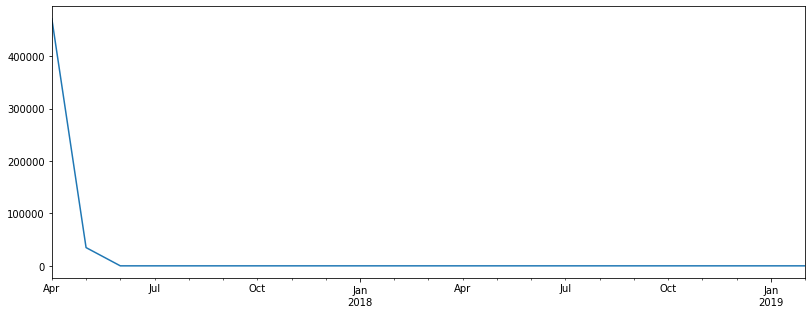

In [56]:
# 상점 아이디가 795번인 상점의 시계열 그래프
store_795 = time_series(resampling_data, 795)
store_plot_795 = store_795.plot()
fig = store_plot_795.get_figure()
fig.set_size_inches(13.5,5)

In [57]:
# 상점 아이디가 795번인 데이터를 시리즈 객체로 변환
store_795 = time_series(resampling_data, 795)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_795)
print('p_val : %f , should_diff : %s' %(p_val, should_diff))

p_val : nan , should_diff : False


## 4. 모델 구축과 검증

### 4-1. 모델링

#### 시계열 분석 (Time-series Data)
- 연도별, 분기별, 월별 등 시계열로 관측되는 자료를 분석하여 미래를 예측하기 위한 분석기법
- x축에는 시간, y축에는 관측값을 나타내어 추세를 빠르게 분석한다.
- 시계열 데이터는 규칙적, 불규칙한 특징을 갖는다.

#### 파이썬에서 R 시계열 패키지 forecast를 통한 모델링

In [58]:
from rpy2.robjects.packages import importr # rpy2 내의 패키지를 불러올 importr 클래스

utils = importr('utils') # utils 패키지를 임포트
utils.install_packages('forecast') # r의 forecast 패키지 설치.
utils.install_packages('forecastHybrid') # r의 forecastHybrid 패키지 설치

rpy2.rinterface.NULL

In [59]:
# robjects: R 함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects

# pandas2ri : 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri 

# pandas2ri를 활성화 
pandas2ri.activate()

# auto_arima 함수 정의 (Str형식 & r코드)
auto_arima = """
    function(ts){
        library(forecast)                             # forecast 패키지 로드
        d_params = ndiffs(ts)                         # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params)   # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3)        # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)     # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')                # amount라는 열로 이름을 지정
        out_df                                        # 예측값 반환
    }
"""
# robjects의 r() 함수: r코드로 정의된 함수와 r의 내장함수를 파이썬에서 사용할 수 있게 해줌
# ts 함수 : 시계열 자료형을 생성해주는 r의 내장함수
# c 함수 : 벡터를 생성해주는 r의 내장함수
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')                 # r의 시계열 자료형으로 만들어주는 함수
c = robjects.r('c')                   # r의 자료형 벡터를 만들어주는 함수

# store_id가 0번인 상점의 데이터를 Down Sampling
store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

# train, test 분리 (마지막 3개월분을 test 데이터로 사용)
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]
    
# R의 ts 함수: R의 time series 자료형으로 변환
# store_0의 amount 값에 대해, start시점에서 시작해서 1개월 주기(frequency=12)로 시계열 자료형으로 변환
train = ts(store_0['amount'], start=c(start_year, start_month), frequency=12) 
print(c(start_year, start_month))

# 자동회귀누적이동평균 model
forecast = auto_arima(train)

# auto_arima함수는 R의 데이터프레임 자료형으로 예측값을 반환하기 때문에,
# pandas2ri 모듈에 있는 ri2py함수를 사용해 R자료형 -> 파이썬 자료형으로 변환
pred = np.sum(pandas2ri.ri2py(forecast).values) # 3개월 매출을 합산


# 예측 성능 평가
print ('auto_arima_store0\n')
test = np.sum(test['amount'])

# MAE
mae = abs(test-pred)
print('MAE: ', mae)

[1] 2016    6

auto_arima_store0

MAE:  65487.313500192715


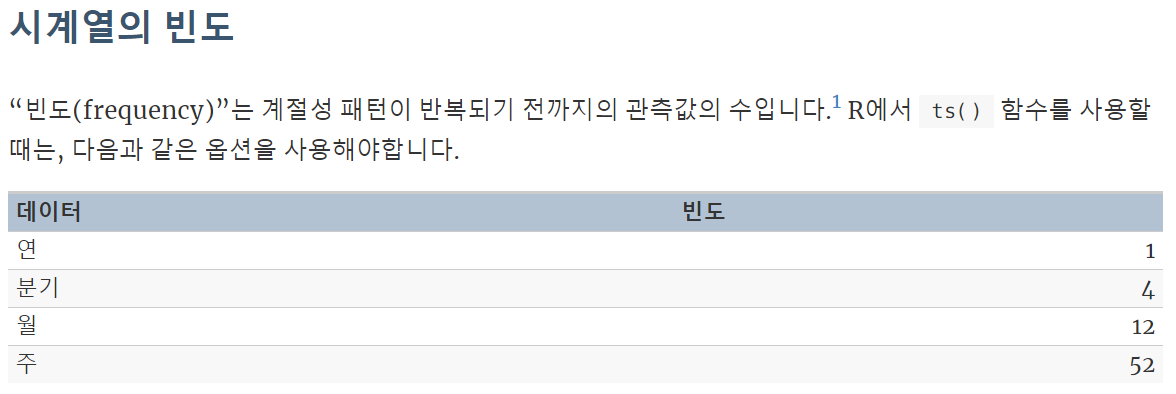

### 4-2. 시계열 모델 선택과 검증 

### AR (자기회귀 모델)
Auto Regressive
- 자신의 이전 관측값이 자신의 이후 관측값에 영향을 주는 모델
- 현시점의 자료가 p 시점 전의 유한개의 과거 자료로 설명될 수 있다는 의미
- 미래 예측에 자기 과거를 사용함  
####  AR(p)모델 
### $y_{t}=c+\phi_{1}y_{t-1}+\phi_{2}y_{t-2}+\cdots+\phi_{p}y_{t-p}+\varepsilon_{t}$<br>
- $y_{t}$ : 현 재 시점의 시계열 자료
- $y_{t-1}, y_{t-2}, \cdots, y_{t-p}$ : 1~p 시점 이전의 시계열 자료
- $\phi_{p}$ : p시점이 현재 시점에 어느정도 영향을 주는지 나타내는 모수
- $\varepsilon_{t}$ : 백색잡음과정. 시계열 분석에서 오차항을 의미함
- 백색잡음과정(White Noise Process): 평균, 분산, 자기공분산이 일정한 정상성 데이터로 변환시키는 과정
- 백색잡음과정 $\varepsilon_{t}$ 는 독립이고, 같은 분포를 따르며, 평균이 0이고 분산이 $\sigma_{\varepsilon}^2$인 확률변수이다.


### MA (이동평균 모델)
Moving Average
- 시간이 지날수록 관측치의 평균값이 지속적으로 증가하거나 감소하는 시계열 모형
- 현 시점의 자료가 유한개의 백색잡음의 선형결합으로 표현되었기때문에 항상 정상성을 만족하므로 정상성 가정이 필요없다.
- 현재 시계열 데이터가 과거 잔차들의 가중평균으로 구성
- 잔차항은 백색잡음을 의미함
- 백색잡음(White Noise): 모든 개별 확률변수들이 서로 독립이고, 동일한 확률분포를 따르는 확률과정을 말한다.
- 현재 데이터는 과거 백색잡음의 평균값으로 설명된다는 것이 이 모델의 핵심
#### MA{q} 모델
### $y_{t}=c+\varepsilon_{t}+\theta_{1}\varepsilon_{t-1}+\theta_{2}\varepsilon_{t-2}+\cdots+\theta_{q}\varepsilon_{t-q}$<br>

### ARIMA (자귀회귀누적이동평균 모델)
Auto Regressive Integrated Moving Average
- AR모델과 MA 모델을 섞은 모델
- 현재와 추세간의 관계를 정의함
- 분기/반기/연간 단위로 다음 지표를 예측하거나 주간/월간 단위로 지표를 리뷰하여 트렌드를 분석하는 기법
- 초기 차분 단계를 한 번 이상 적용해 비정상성을 제거할 수 있음
#### ARIMA( p, d, q) 모델
### $y_{t}'=c+\phi_{1}y'_{t-1}+\cdots+\phi_{p}y'_{t-p}+\theta_{1}\varepsilon_{t-1}+\cdots+\theta_{q}\varepsilon_{t-q}+\varepsilon_{t}$<br>
-  $y_{t}'$:  차분을 구한 시계열<br>
- p : 자기회귀(AR)의 부분 차수
- d : 1차 차분이 포함된 정도
- q : 이동평균(MA)의 부분 차수<br><br>
- R의 forecast 패키지의 ndiffs함수-> 차분 횟수를 결정할 때, 적절한 차분 횟수를 반환 해 줌
- R의 forecast 패키지의 auto.arima함수-> 최적화된 AR 항의 p값, MA항의 q값, I항에 대한 d값을 계산 해 줌.

#### ARIMA

In [60]:
# r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects
# 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri 

# pandas2ri를 활성화 
pandas2ri.activate()

# auto_arima 함수 정의 (Str형식 & r코드)
auto_arima = """
    function(ts){
        library(forecast)                            # forecast 패키지 로드
        d_params = ndiffs(ts)                        # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params)  # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3)       # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)    # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')               # amount라는 열로 이름을 지정
        out_df                                       # 예측값 반환
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)# str 형식으로 정의된 auto_arima
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

results = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    
    # train, test 분리 (마지막 3개월분을 test 데이터로 사용)
    store = store[store.index <= len(store)-4]
    test = store[store.index > len(store)-4]
    
    start_year = int(min(store['year_month'])[:4]) ## 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) ## 영업 시작 월
    
    
    # R의 ts 함수로 time series 데이터로 변환
    # 1년은 12개월이므로, frequency = 12
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    
    # 자동회귀누적이동평균 model
    forecast = auto_arima(train)
    
    # auto_arima함수는 R의 데이터프레임 자료형으로 예측값을 반환하기 때문에,
    # pandas2ri 모듈에 있는 ri2py함수를 사용해 R자료형 -> 파이썬 자료형으로 변환
    # 3개월 매출을 합산, pred로 저장
    pred = np.sum(pandas2ri.ri2py(forecast).values)
    
    # 예측 성능 평가
    test = np.sum(test['amount'])
    
    error = abs(test-pred)
    
    results.append({'test': test, 'pred': pred, 'error': error})

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [02:22<00:00, 13.77it/s]


In [61]:
from pandas import DataFrame
df = DataFrame (results,columns=['test','pred', 'error'])
df

,test,pred,error
0,2.066857e+06,2.078599e+06,11741.816924
1,2.393571e+05,2.423571e+05,3000.000000
2,1.176143e+06,6.930519e+05,483090.961079
3,2.409571e+06,2.697655e+06,288083.366213
4,9.032286e+05,1.047693e+06,144464.473887
...,...,...,...
1962,2.306143e+06,2.245505e+06,60638.265306
1963,5.876714e+05,8.963628e+05,308691.400614
1964,2.745000e+05,3.648425e+05,90342.493174
1965,1.949714e+06,1.793089e+06,156625.000000


In [62]:
df.describe()

,test,pred,error
count,1.967000e+03,1.967000e+03,1.967000e+03
mean,3.326176e+06,3.347915e+06,5.966504e+05
std,4.986604e+06,4.892882e+06,1.040710e+06
min,6.000000e+00,-7.786497e+05,0.000000e+00
25%,1.120643e+06,1.101057e+06,9.236351e+04
50%,2.138429e+06,2.172780e+06,2.704286e+05
75%,3.994286e+06,4.115715e+06,6.481143e+05
max,1.487844e+08,1.412533e+08,1.216268e+07


In [63]:
mae_arima = df['error'].mean()

In [64]:
mae_arima

596650.3769188446

In [65]:
len(resampling_data.store_id.unique())

1967

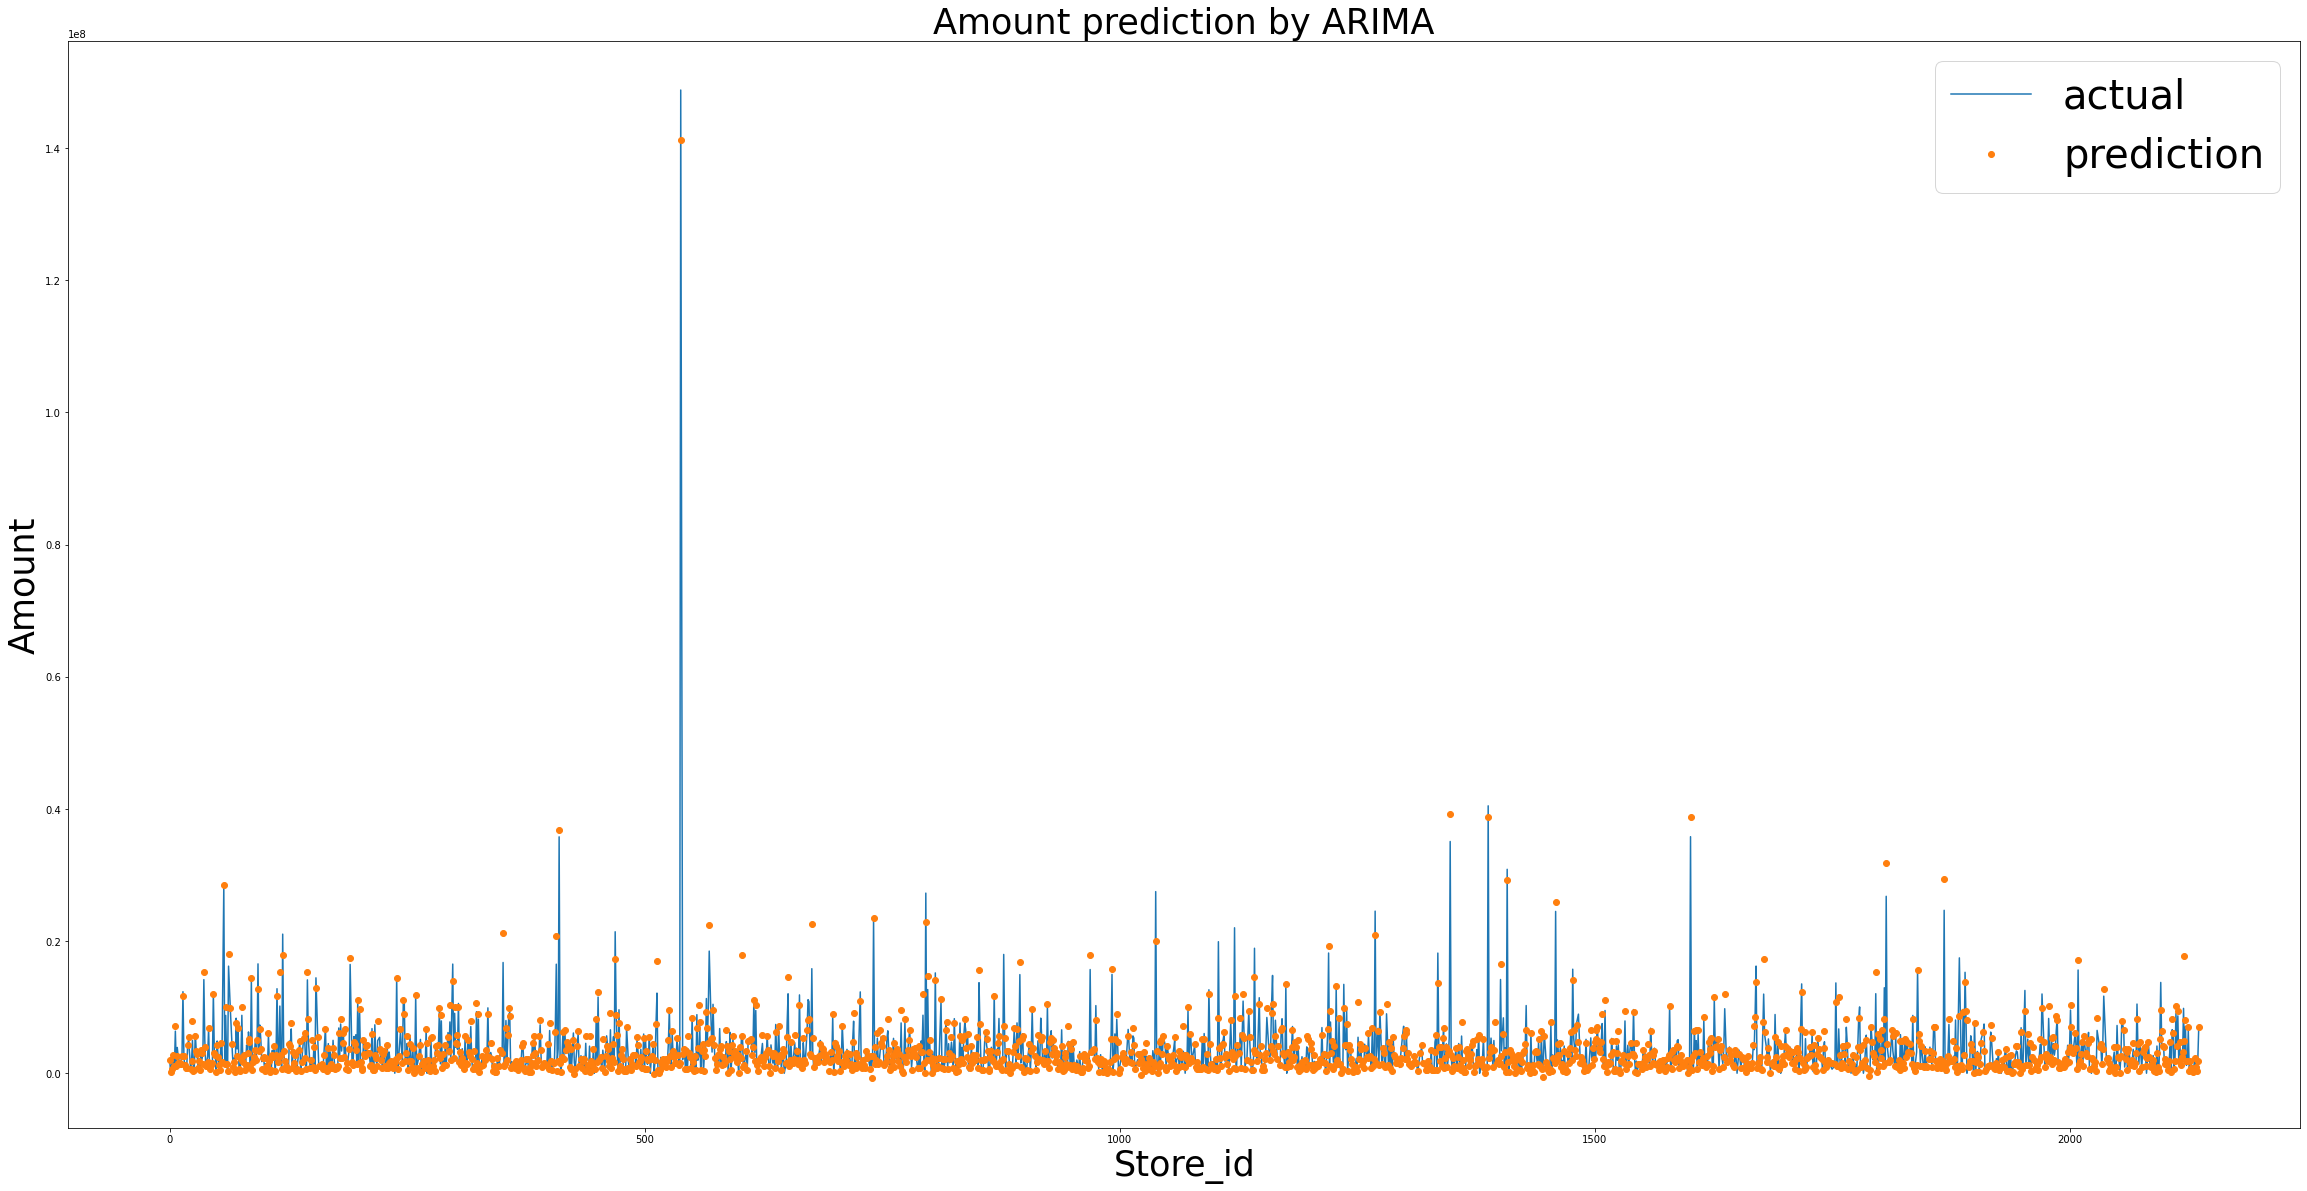

In [66]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,20))

x_values = list(resampling_data.store_id.unique())
y_values1 = list(df['test'].values)
y_values2 = list(df['pred'].values)

plt.plot(x_values, y_values1)
plt.plot(x_values, y_values2,'o')

plt.xlabel('Store_id', fontsize=35)
plt.ylabel('Amount', fontsize=35)
plt.title('Amount prediction by ARIMA', fontsize=35)

plt.legend(['actual', 'prediction'], fontsize=40)

plt.show()

#### 지수평활법

1. 단순 지수평활법
2. 홀트의 선형추세 기법
3. 여러 지수평활 모델 中 최적의 모델 찾기
4. 최종 예측 진행


#### 1) 단순 지수평활법
* 가장 최근 관측값을 가장 중요하게 생각
* 이전의 모든 관측값은 미래를 예측할 때 아무런 정보도 주지 않는다고 가정
* 미래를 예측할 때, 가장 최근에 관측된 값에 가중치를 더 많이 줌
* 추세나 계절성이 없을 때 주로 사용<br>
   ### $ \hat y_{T+1|T} = \alpha y_{T}+\alpha (1-\alpha)y_{T-1}+\alpha (1-\alpha)^2y_{T-2}+\cdots $


* $\alpha$는 평활매개변수, $0<\alpha<1$
* 가중치가 감소하는 비율은 $\alpha$ 값을 이용하여 조정
* 가중치에 해당하는 계수 -> 잔차의 제곱의 합(SSE)를 최소화하여 추정
* 잔차(residual)은 $e_{t}=y_{t}-y'_{t}$ 로 명시<br>
#### SSE  =  $\sum_{t=1}^{T}(y_{t}-y'_{t|t-1})^2=\sum_{t=1}^{T}e^2_{t}$

#### 2) 홀트의 선형추세 기법
* 추세가 있는 데이터를 예측할 수 있도록 단순 지수평활법을 확장한 방법
* 단순 지수평활법에서 현재 시계열의 관측값의 가중평균(수준식)과 추세의 이동평균(추세식)을 고려
* 예측식과 두 개의 평활식을 포함<br>
    #### 예측식: $ \hat y_{t+h|t} = l_{t}+hb_{t} $
    $l_{t}$ : 시간 t에서 현재 시계열의 수준 추정값 (관측값의 가중평균) <br>
    $b_{t}$ : 시간 t에서 현재 시계열의 추세 추정값 (추정된 추세의 이동평균)<br>
       
    #### 수준식: $ l_{t} = \alpha y_{t}+(1-\alpha)(l_{t-1}+b_{t-1}) $
    $\alpha$ : 수준의 평활 매개변수<br>
    
    #### 추세식: $ b_{t} = \beta^{*}(l_{t}-l_{t-1})+(1-\beta^{*})b_{t-1} $
    $\beta$ : 추세에 대한 평활 매개변수<br>


#### 3) 여러 지수평활 모델中 현재 주어진 시계열 데이터에 맞는 모델 찾기 
* R의 ets() 함수 -> 시계열 데이터에 대해 AIC 값을 최소로 하는 지수평활 모델을 추정 
* AIC는 주어진 데이터셋에서 통계 모델의 상대적 품질을 나타내는 값
* AIC: Akaike’s Information Criterion; 아카이케의 정보 기준<br>
* AIC 값이 낮을수록 좋은 모델<br>
#### AIC = -2ln(L) + 2k<br>
* 2ln(L) : 모델의 적합도  
* k : 추정된 모델의 파라미터 개수  
* L : 우도(likelihood), 모델의 가능도
* AIC는 모델의 적합도가 높고 파라미터 개수가 적은 모델을 찾을 때 도움이 되는 지표 

R의 forecast 패키지에 있는 ets()함수를 이용하여<br>
1,967개 상점에 가장 적합한 지수평활 모델을 찾고 예측을 진행

In [67]:
# r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects
# 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri 

# pandas2ri를 활성화 
pandas2ri.activate()

# ets 함수 정의 (Str형식 & r코드)
ets = """
    function(ts){
        library(forecast)                            # forecast 패키지 로드
        model = ets(ts)                              # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3)       # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)    # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')               # amount라는 열로 이름을 지정
        out_df                                       # 예측값 반환
    }
"""
# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

# 예측값(상점별 미래 3개월 매출액 총합을 예측한 값)을 리스트로 저장
results = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    
    # train, test 분리 (마지막 3개월분을 test 데이터로 사용)
    store = store[store.index <= len(store)-4]
    test = store[store.index > len(store)-4]
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    
    # 지수평활법
    forecast = ets(train)
    
    # 3개월 매출을 합산, final_pred에 추가
    pred = np.sum(pandas2ri.ri2py(forecast).values)
    
    # 예측 성능 평가
    test = np.sum(test['amount'])

    # MAE
    error = abs(test-pred)
    
    results.append({'test': test, 'pred': pred, 'error': error})

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [15:53<00:00,  2.06it/s]


In [68]:
from pandas import DataFrame
df = DataFrame (results,columns=['test','pred', 'error'])
df

,test,pred,error
0,2.066857e+06,2.101851e+06,34993.525912
1,2.393571e+05,2.523069e+05,12949.735353
2,1.176143e+06,1.146941e+06,29201.578868
3,2.409571e+06,2.538548e+06,128976.334654
4,9.032286e+05,1.091468e+06,188239.048609
...,...,...,...
1962,2.306143e+06,2.245527e+06,60615.408784
1963,5.876714e+05,2.541752e+05,333496.235985
1964,2.745000e+05,3.779021e+05,103402.143433
1965,1.949714e+06,1.767796e+06,181918.160668


In [69]:
df.describe()

,test,pred,error
count,1.967000e+03,1.967000e+03,1.967000e+03
mean,3.326176e+06,3.359249e+06,4.104171e+05
std,4.986604e+06,4.970144e+06,7.761027e+05
min,6.000000e+00,-8.227302e+05,0.000000e+00
25%,1.120643e+06,1.135777e+06,6.380871e+04
50%,2.138429e+06,2.167381e+06,1.766390e+05
75%,3.994286e+06,4.093144e+06,4.189582e+05
max,1.487844e+08,1.472693e+08,1.221320e+07


In [70]:
mae_ets = df['error'].mean()

In [71]:
mae_ets

410417.0520634708

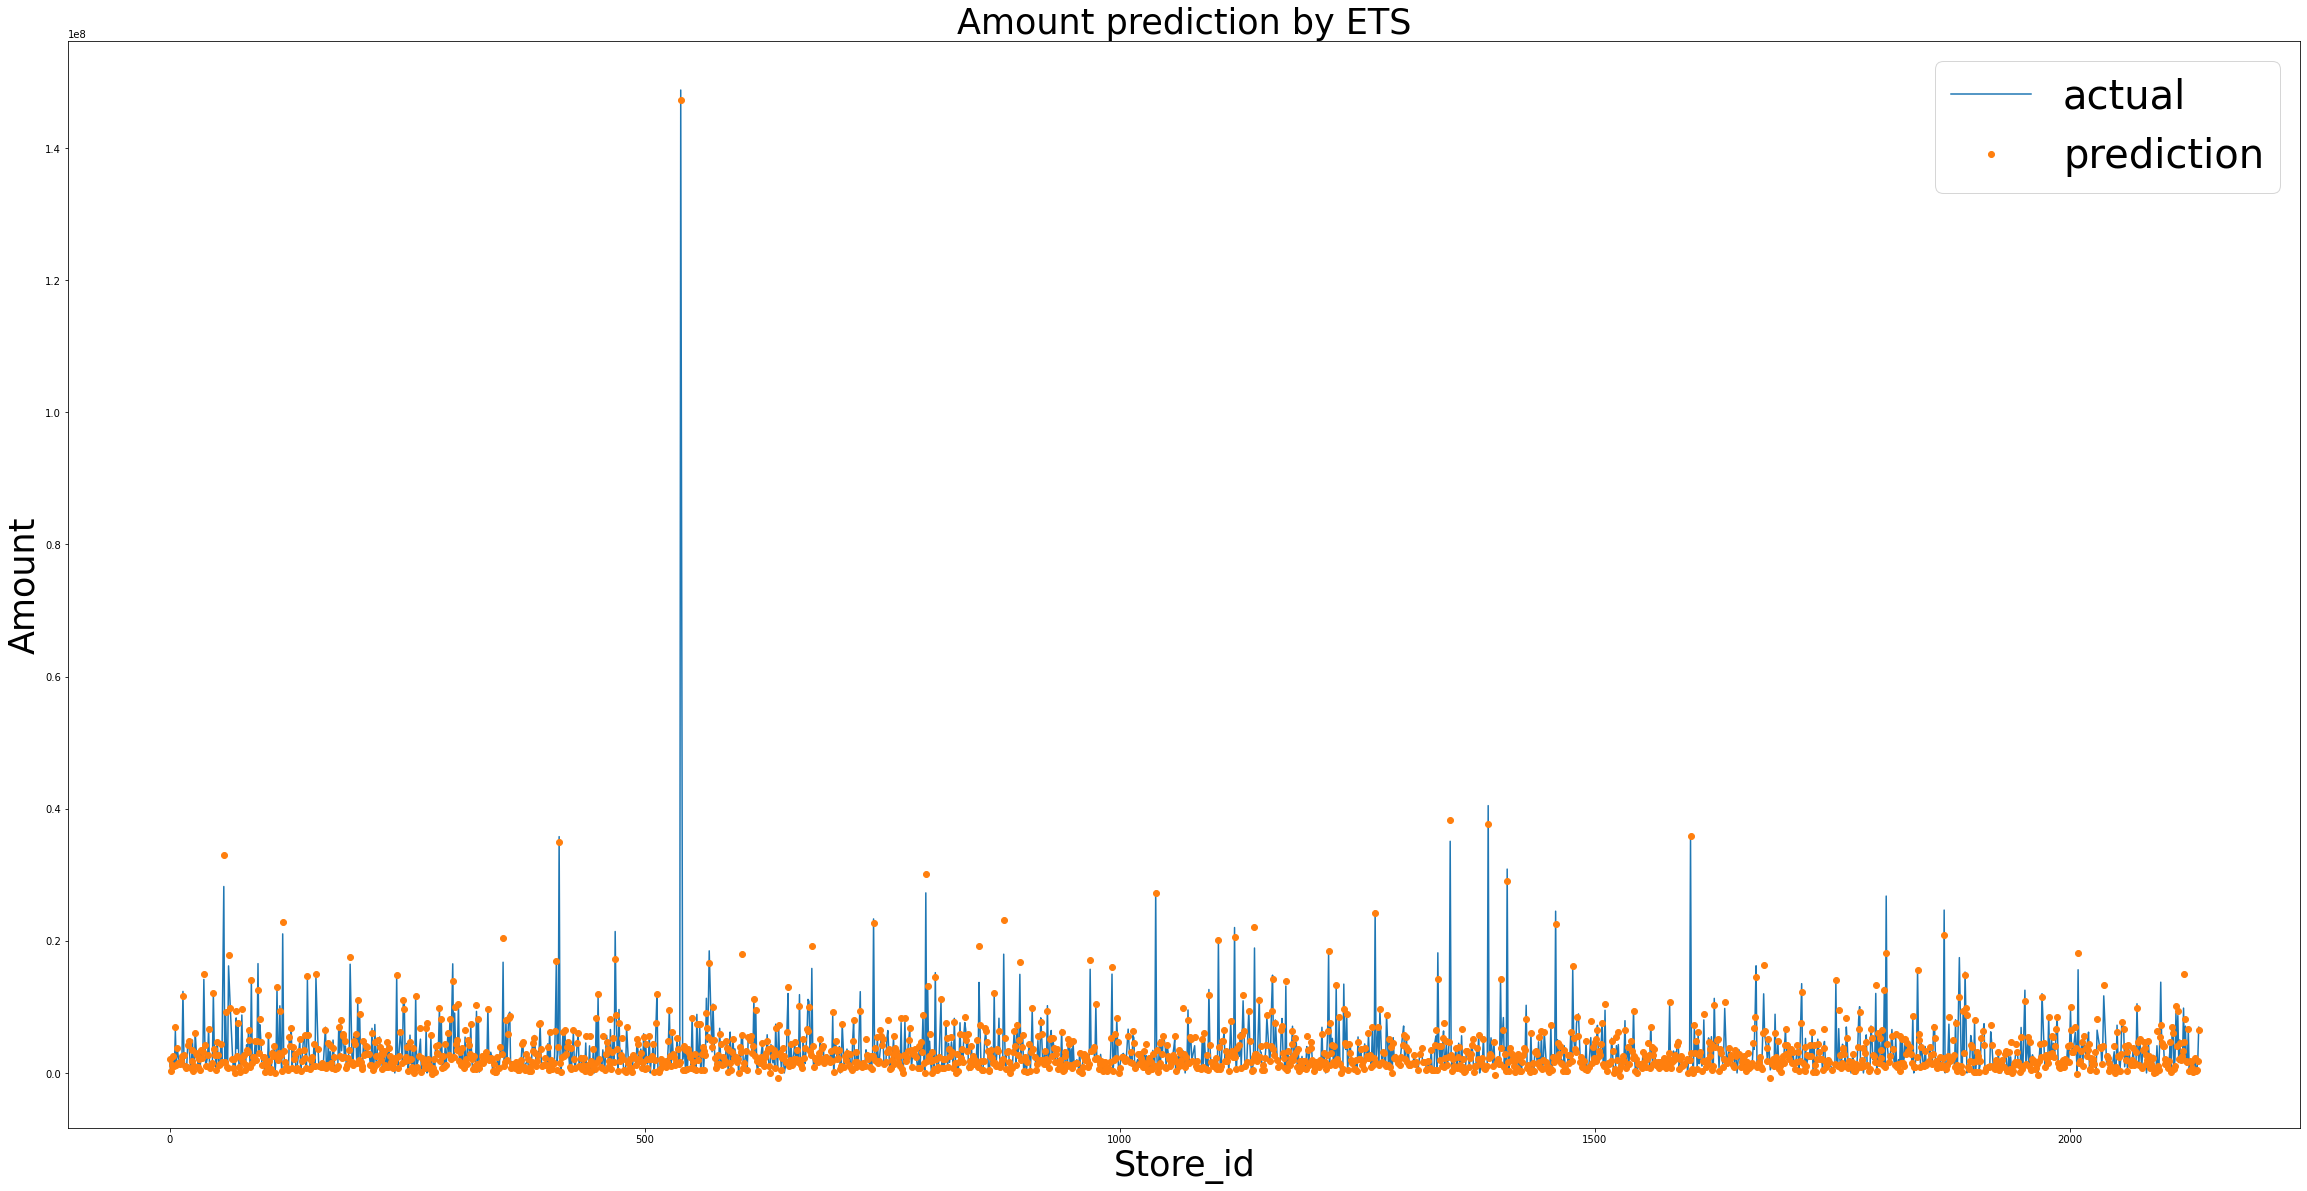

In [72]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,20))

x_values = list(resampling_data.store_id.unique())
y_values1 = list(df['test'].values)
y_values2 = list(df['pred'].values)

plt.plot(x_values, y_values1)
plt.plot(x_values, y_values2,'o')

plt.xlabel('Store_id', fontsize=35)
plt.ylabel('Amount', fontsize=35)
plt.title('Amount prediction by ETS', fontsize=35)

plt.legend(['actual', 'prediction'], fontsize=40)

plt.show()

#### STL 분해를 적용한 지수평활법

Seasonal and Trend decomposition using Loess; STL<br>
Loess를 사용한 계절성과 추세 분해 (Loess: 비선형 관계를 추정하기 위한 기법)
- 시계열 데이터가 가진 시간 주기를 알고있는 경우,<br>
    시계열 데이터를 계절성과 추세, 나머지 성분으로 분해하여 분석하는 기법
- 파이썬의 statsmodels 패키지에서 STL 분해 기능을 제공함

*예시> store_id가 0번인 데이터에 대해 STL 분해*
- statsmodels의 seasonal_decompose() 함수는 STL 분해 기능을 제공함
- 첫번째 인자에 numpy array형식으로 매출액 데이터를 넘겨줌
- freq 인자는 월별로 다운 샘플링하며, 1년은 12개월이므로 freq=12로 설정

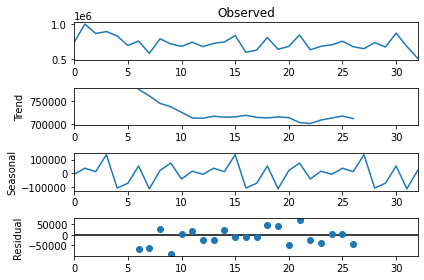

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)

# STL 분해
stl = seasonal_decompose(store_0.values, freq=12)
stl.plot()
plt.show()

- 첫번째 그래프: 관측된 실제 매출액
- 두번째 그래프: 추세(Trend)
- 세번째 그래프: 계절성(Seasonal)
- 네번째 그래프: 나머지 성분(Residual)
#### 실제 관측값 = 추세 + 계절성 + 나머지 성분<br>
- STL분해를 하는 이유 : 매출의 전반적인 트렌드, 계절성 등을 고려해야 정확한 모델을 만들 수 있기 때문
- STL 분해를 적용하고 지수평활법을 통해 예측까지 진행 -> R의 Forecast패키지의 stlm()함수 사용 

In [74]:
# r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
import rpy2.robjects as robjects 
# 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
from rpy2.robjects import pandas2ri 

# pandas2ri를 활성화 
pandas2ri.activate()

# stlm 함수 정의 (Str형식 & r코드)
stlm = """
    function(ts){
        library(forecast)                                    # forecast 패키지 로드    
        model = stlm(ts, s.window="periodic", method='ets')  # STL 분해 후 지수평활법을 통한 예측 
        forecasted_data = forecast(model, h=3)               # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)            # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')                       # amount라는 열로 이름을 지정
        out_df                                               # 예측값 반환
    }
"""

# ets 함수 정의 (Str형식 & r코드)
ets = """
    function(ts){
        library(forecast)                           # forecast 패키지 로드
        model = ets(ts)                             # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3)      # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)   # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')              # amount라는 열로 이름을 지정
        out_df                                      # 예측값 반환
    }
"""
# r() 함수로 r을 파이썬에서 사용 가능
stlm = robjects.r(stlm)# str 형식으로 정의된 stlm
ets = robjects.r(ets)# str 형식으로 정의된 ets
ts = robjects.r('ts')# r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수

# 예측값(상점별 미래 3개월 매출액 총합을 예측한 값)을 리스트로 저장
results = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    
    # train, test 분리 (마지막 3개월분을 test 데이터로 사용)
    store = store[store.index <= len(store)-4]
    test = store[store.index > len(store)-4]
    
    # 상점별 데이터 길이
    data_len = len(store)
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월

    # R의 ts 함수로 time series 데이터로 변환
    train = ts(store['amount'], start=c(start_year, start_month), frequency=12) 
    
    #
    # STL 분해를 적용할 때 최소 2시즌(24개월)보다 많은 데이터가 필요하기 때문에,
    # 24개월보다 많은 경우에만 -> STL 분해를 적용
    # 그 외 -> 지수평활모델 적용
    #
    
    # STL 분해를 적용한 지수평활 model
    if data_len > 24:
        forecast = stlm(train)
        
    # 지수평활 model
    else:
        forecast = ets(train)  
        
    # 3개월 매출을 합산, pred로 저장
    pred = np.sum(pandas2ri.ri2py(forecast).values)
    
    # 예측 성능 평가
    test = np.sum(test['amount'])

    # MAE
    error = abs(test-pred)
    results.append({'test': test, 'pred': pred, 'error': error})

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [03:30<00:00,  9.32it/s]


In [75]:
from pandas import DataFrame
df = DataFrame (results,columns=['test','pred', 'error'])
df

,test,pred,error
0,2.066857e+06,2.036001e+06,30855.779058
1,2.393571e+05,2.892541e+05,49896.917453
2,1.176143e+06,1.118967e+06,57176.294127
3,2.409571e+06,2.283015e+06,126556.654273
4,9.032286e+05,9.462386e+05,43009.998480
...,...,...,...
1962,2.306143e+06,2.170406e+06,135736.587069
1963,5.876714e+05,-5.375387e+03,593046.815202
1964,2.745000e+05,6.604846e+05,385984.649341
1965,1.949714e+06,1.698623e+06,251091.188152


In [76]:
df.describe()

,test,pred,error
count,1.967000e+03,1.967000e+03,1.967000e+03
mean,3.326176e+06,3.359008e+06,6.568678e+05
std,4.986604e+06,5.559064e+06,1.348640e+06
min,6.000000e+00,-6.763677e+06,1.000000e+01
25%,1.120643e+06,1.041648e+06,1.082973e+05
50%,2.138429e+06,2.139765e+06,2.874552e+05
75%,3.994286e+06,4.110328e+06,7.038323e+05
max,1.487844e+08,1.775849e+08,2.880046e+07


In [77]:
mae_stlm = df['error'].mean()

In [78]:
mae_stlm

656867.7985856216

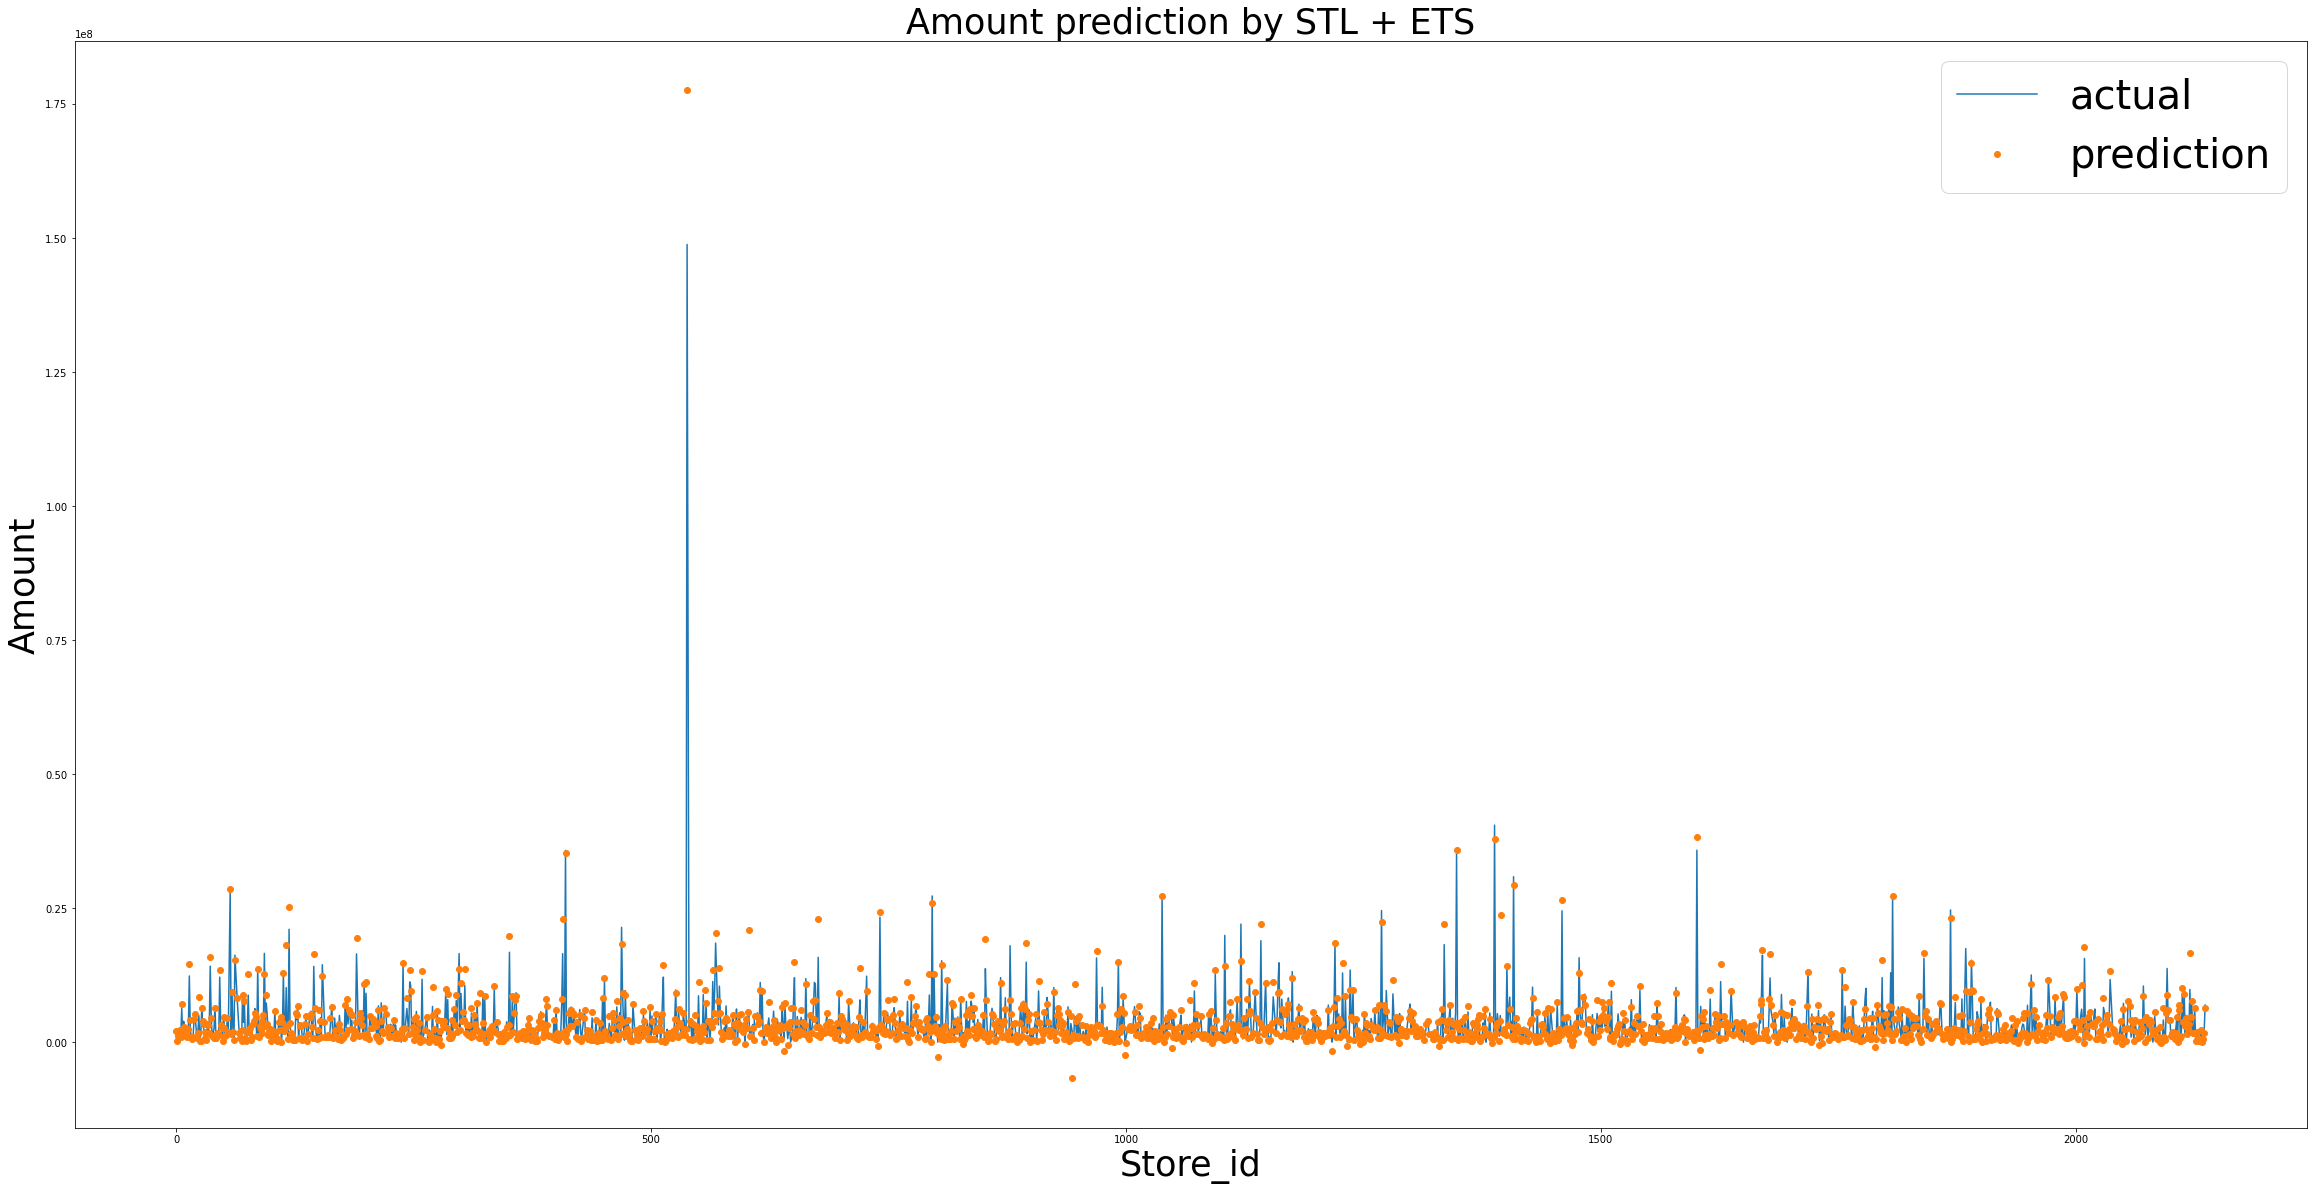

In [79]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,20))

x_values = list(resampling_data.store_id.unique())
y_values1 = list(df['test'].values)
y_values2 = list(df['pred'].values)

plt.plot(x_values, y_values1)
plt.plot(x_values, y_values2,'o')

plt.xlabel('Store_id', fontsize=35)
plt.ylabel('Amount', fontsize=35)
plt.title('Amount prediction by STL + ETS', fontsize=35)

plt.legend(['actual', 'prediction'], fontsize=40)

plt.show()

-  s.windows: 계절 윈도우 / t.windows: 추세 윈도우
- 계절 및 추세성분이 변하는 '정도'를 조절할 수 있으며, 값이 작을수록 급격하게 변함
- 인자 값은 둘 다 홀수여야 함
- s.windows는 기본 설정값이 없기 때문에 값을 설정해줘야 함. " s.windows='periodic " -> 계절 성분을 주기적으로 고정
- t.windows는 기본 설정값이 있기 때문에 값을 정하는 것은 선택사항임

#### -> 완성된 제출 파일을 데이콘에 제출 & 리더보드 점수 확인 -> 21등 (869,178점)
    ( 앞에서 진행했던 ARIMA 모델과 지수평활법 모델보다 낮은 점수)

#### [예측 성능 평가 결과]
지수평활법 > ARIMA > STL 분해를 적용한 지수평활법

성능평가 순위 | 모델 | 리더보드 순위 | mae 평균
:--------:|:--------:|:--------:|:--------:|
1위 | 지수평활법 | 10위 | 794,263점
2위 | ARIMA | 18위 | 844,384점
3위 | STL분해 | 21위 | 869,178점

## 5. 성능 향상을 위한 방법

1) 데이터 전처리를 통한 성능향상
#### --> 로그 정규화<br>
2) 여러 모델을 결합해서 예측을 시도하는 앙상블
#### --> ARIMA, 지수평활법, STL 분해를 적용한 지수평활법의 앙상블 예측 진행<br>

### 5-1. 상점 매출액의 로그 정규화

#### 로그 정규화를 하는 이유: 매출액의 작은 변동을 안정화 하여, 더 큰 트렌드를 파악하기 위함

예시> store_id가 0번인 상점의 매출액에 대해 로그 정규화 진행 & ARIMA모델의 예측 성능에 차이가 있는지 비교

In [80]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

# auto_arima 함수 정의 (Str형식 & r코드)
auto_arima = """
    function(ts){
        library(forecast)                             # forecast 패키지 로드
        d_params = ndiffs(ts)                         # 시계열 자료의 차분 횟수 계산
        model = auto.arima(ts, max.p=2, d=d_params)   # auto.arima 모델 생성
        forecasted_data = forecast(model, h=3)        # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)     # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')                # amount라는 열로 이름을 지정
        out_df                                        # 예측값 반환
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
auto_arima = robjects.r(auto_arima)
ts = robjects.r('ts')   # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c')     # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp') # 로그 역변환 함수

# 0번 상점 추출
store_0 = resampling_data[resampling_data['store_id']==0]
start_year = int(min(store_0['year_month'])[:4]) # 영업 시작 년도
start_month = int(min(store_0['year_month'])[5:]) # 영업 시작 월

print(store_0)
print('-'*30)
print(len(store_0))

    store_id year_month        amount
0          0    2016-06  7.470000e+05
1          0    2016-07  1.005000e+06
2          0    2016-08  8.697143e+05
3          0    2016-09  8.978571e+05
4          0    2016-10  8.354286e+05
5          0    2016-11  6.970000e+05
6          0    2016-12  7.618571e+05
7          0    2017-01  5.856429e+05
8          0    2017-02  7.940000e+05
9          0    2017-03  7.202571e+05
10         0    2017-04  6.852857e+05
11         0    2017-05  7.444286e+05
12         0    2017-06  6.820000e+05
13         0    2017-07  7.282857e+05
14         0    2017-08  7.490000e+05
15         0    2017-09  8.408571e+05
16         0    2017-10  6.005714e+05
17         0    2017-11  6.308571e+05
18         0    2017-12  8.127143e+05
19         0    2018-01  6.431429e+05
20         0    2018-02  6.852857e+05
21         0    2018-03  8.484286e+05
22         0    2018-04  6.361429e+05
23         0    2018-05  6.864286e+05
24         0    2018-06  7.072857e+05
25         0

In [81]:
# train, test 분리
# 2018년 12월 이전 -> train
# 2018년 12월 부터 -> test
train = store_0[store_0.index <= len(store_0)-4]
test = store_0[store_0.index > len(store_0)-4]

# R의 ts 함수로 r의 time series 자료형으로 변환
# numpy의 log()함수를 이용하여 로그정규화
train_log = ts(log(train['amount']), start=c(start_year, start_month), frequency=12) # log 정규화 
train = ts(train['amount'], start=c(start_year, start_month), frequency=12) # log 정규화를 하지 않음

# model arima
forecast_log = auto_arima(train_log)
forecast = auto_arima(train)

# pred
pred_log = np.sum(pandas2ri.ri2py(exp(forecast_log)).values) #로그 역변환 후 3개월 합산
pred = np.sum(pandas2ri.ri2py(forecast).values) #3개월 매출을 합산

# test(2018-12~2019-02)
test = np.sum(test['amount'])

# mae
print('log-regularization mae: ', abs(test-pred_log))
print('mae:', abs(test-pred))

log-regularization mae:  2401.9664819482714
mae: 5884.674066892825


손실함수는 대회 평가척도인 MAE를 사용<br>
log 정규화를 했을때의 MAE가 더 적은 것을 확인할 수 있으며, 성능이 더 우수하다고 할 수 있다.

#### MAE ( Mean Average Error)
- 실제 값과 예측값의 차이(Error)를 절대값으로 변환해서 평균화
- 에러에 절대값을 취하기 때문에, 에러의 크기가 그대로 반영된다.
- 에러에 따른 손실이 선형적으로 올라갈 때 적합
- 이상치가 많을 때 사용
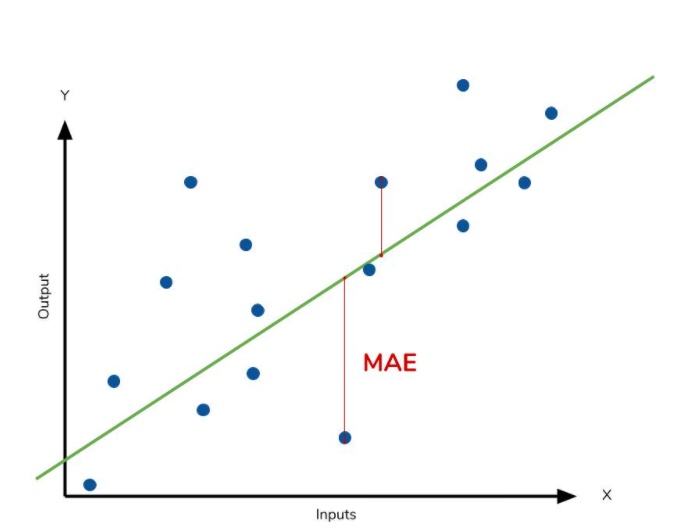

#### 매출액 변동계수를 고려해 로그 정규화를 진행

#### 변동계수 (Coefficient of Variation; CV)  
- 표준편차를 평균으로 나눈 지표  
- 변동 계수의 값이 클수록 상대적인 차이가 크다는 것을 의미  
### $ CV = \frac \sigma {\overline x} $

<b>- 매출액 변동계수가 높은 상점을 로그 정규화했을 때 예측 성능이 저하되는 것을 발견  
<b>- 매출액 변동계수가 0.3 미만인 상점만 로그 정규화를 진행하여 예측  
#### 가장 성능이 좋았던 지수평활법을 이용해 변동계수를 고려해서 로그 정규화 한 후 예측값 생성  

In [82]:
# 매출 변동 계수를 구하는 함수
def coefficient_variation(df, i):
    cv_data = df.groupby(['store_id']).amount.std()/df.groupby(['store_id']).amount.mean()
    cv = cv_data[i]
    return cv  # 상점별 변동계수를 반환

In [83]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

# ets 함수 정의 (Str형식 & r코드)
ets = """
    function(ts){
        library(forecast)                             # forecast 패키지 로드
        model = ets(ts)                               # AIC가 낮은 지수평활 모델을 찾음 
        forecasted_data = forecast(model, h=3)        # 이후 3개월(h=3)을 예측
        out_df = data.frame(forecasted_data$mean)     # 예측값을 R의 데이터프레임으로 변환
        colnames(out_df) = c('amount')                # amount라는 열로 이름을 지정
        out_df                                        # 예측값 반환
    }
"""

# r() 함수로 r 자료형을 파이썬에서 사용 가능
ets = robjects.r(ets)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

results = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    
    # train, test 분리 (마지막 3개월분을 test 데이터로 사용)
    store = store[store.index <= len(store)-4]
    test = store[store.index > len(store)-4]
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    # 매출의 변동계수 구하는 함수 실행 (상점별)
    cv = coefficient_variation(resampling_data, i)
    
    
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        # R의 ts 함수로 time series 데이터로 변환
        # 로그 정규화
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12)
        
        # ets model (가장 적합한 지수평활 모델 찾아서 예측)
        forecast_log = ets(train_log)
        
        # 예측값을 로그 역변환해서 final_pred 리스트에 추가
        pred = np.sum(pandas2ri.ri2py(exp(forecast_log)).values)
        
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        # R의 ts 함수로 time series 데이터로 변환
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        
        # 지수평활법
        forecast = ets(train)
        pred = np.sum(pandas2ri.ri2py(forecast).values)
        
    # 예측 성능 평가
    test = np.sum(test['amount'])

    # MAE
    error = abs(test-pred)
    
    results.append({'test':test, 'pred':pred, 'error': error})

model_etslog = ('지수평활법 + 로그정규화', error)

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [19:52<00:00,  1.65it/s]


In [84]:
from pandas import DataFrame
df = DataFrame (results,columns=['test','pred', 'error'])
df

,test,pred,error
0,2.066857e+06,2.089099e+06,22242.094227
1,2.393571e+05,2.344161e+05,4941.063032
2,1.176143e+06,1.146941e+06,29201.578868
3,2.409571e+06,2.525347e+06,115775.890900
4,9.032286e+05,1.091468e+06,188239.048609
...,...,...,...
1962,2.306143e+06,2.178831e+06,127311.618908
1963,5.876714e+05,2.541752e+05,333496.235985
1964,2.745000e+05,3.779021e+05,103402.143433
1965,1.949714e+06,1.755722e+06,193992.051687


In [85]:
df.describe()

,test,pred,error
count,1.967000e+03,1.967000e+03,1.967000e+03
mean,3.326176e+06,3.335533e+06,4.171942e+05
std,4.986604e+06,4.915038e+06,7.869014e+05
min,6.000000e+00,-8.227302e+05,0.000000e+00
25%,1.120643e+06,1.135385e+06,6.687856e+04
50%,2.138429e+06,2.153895e+06,1.783263e+05
75%,3.994286e+06,4.064949e+06,4.218570e+05
max,1.487844e+08,1.447928e+08,1.221320e+07


In [86]:
mae_log = df['error'].mean()

In [87]:
mae_log

417194.1645171428

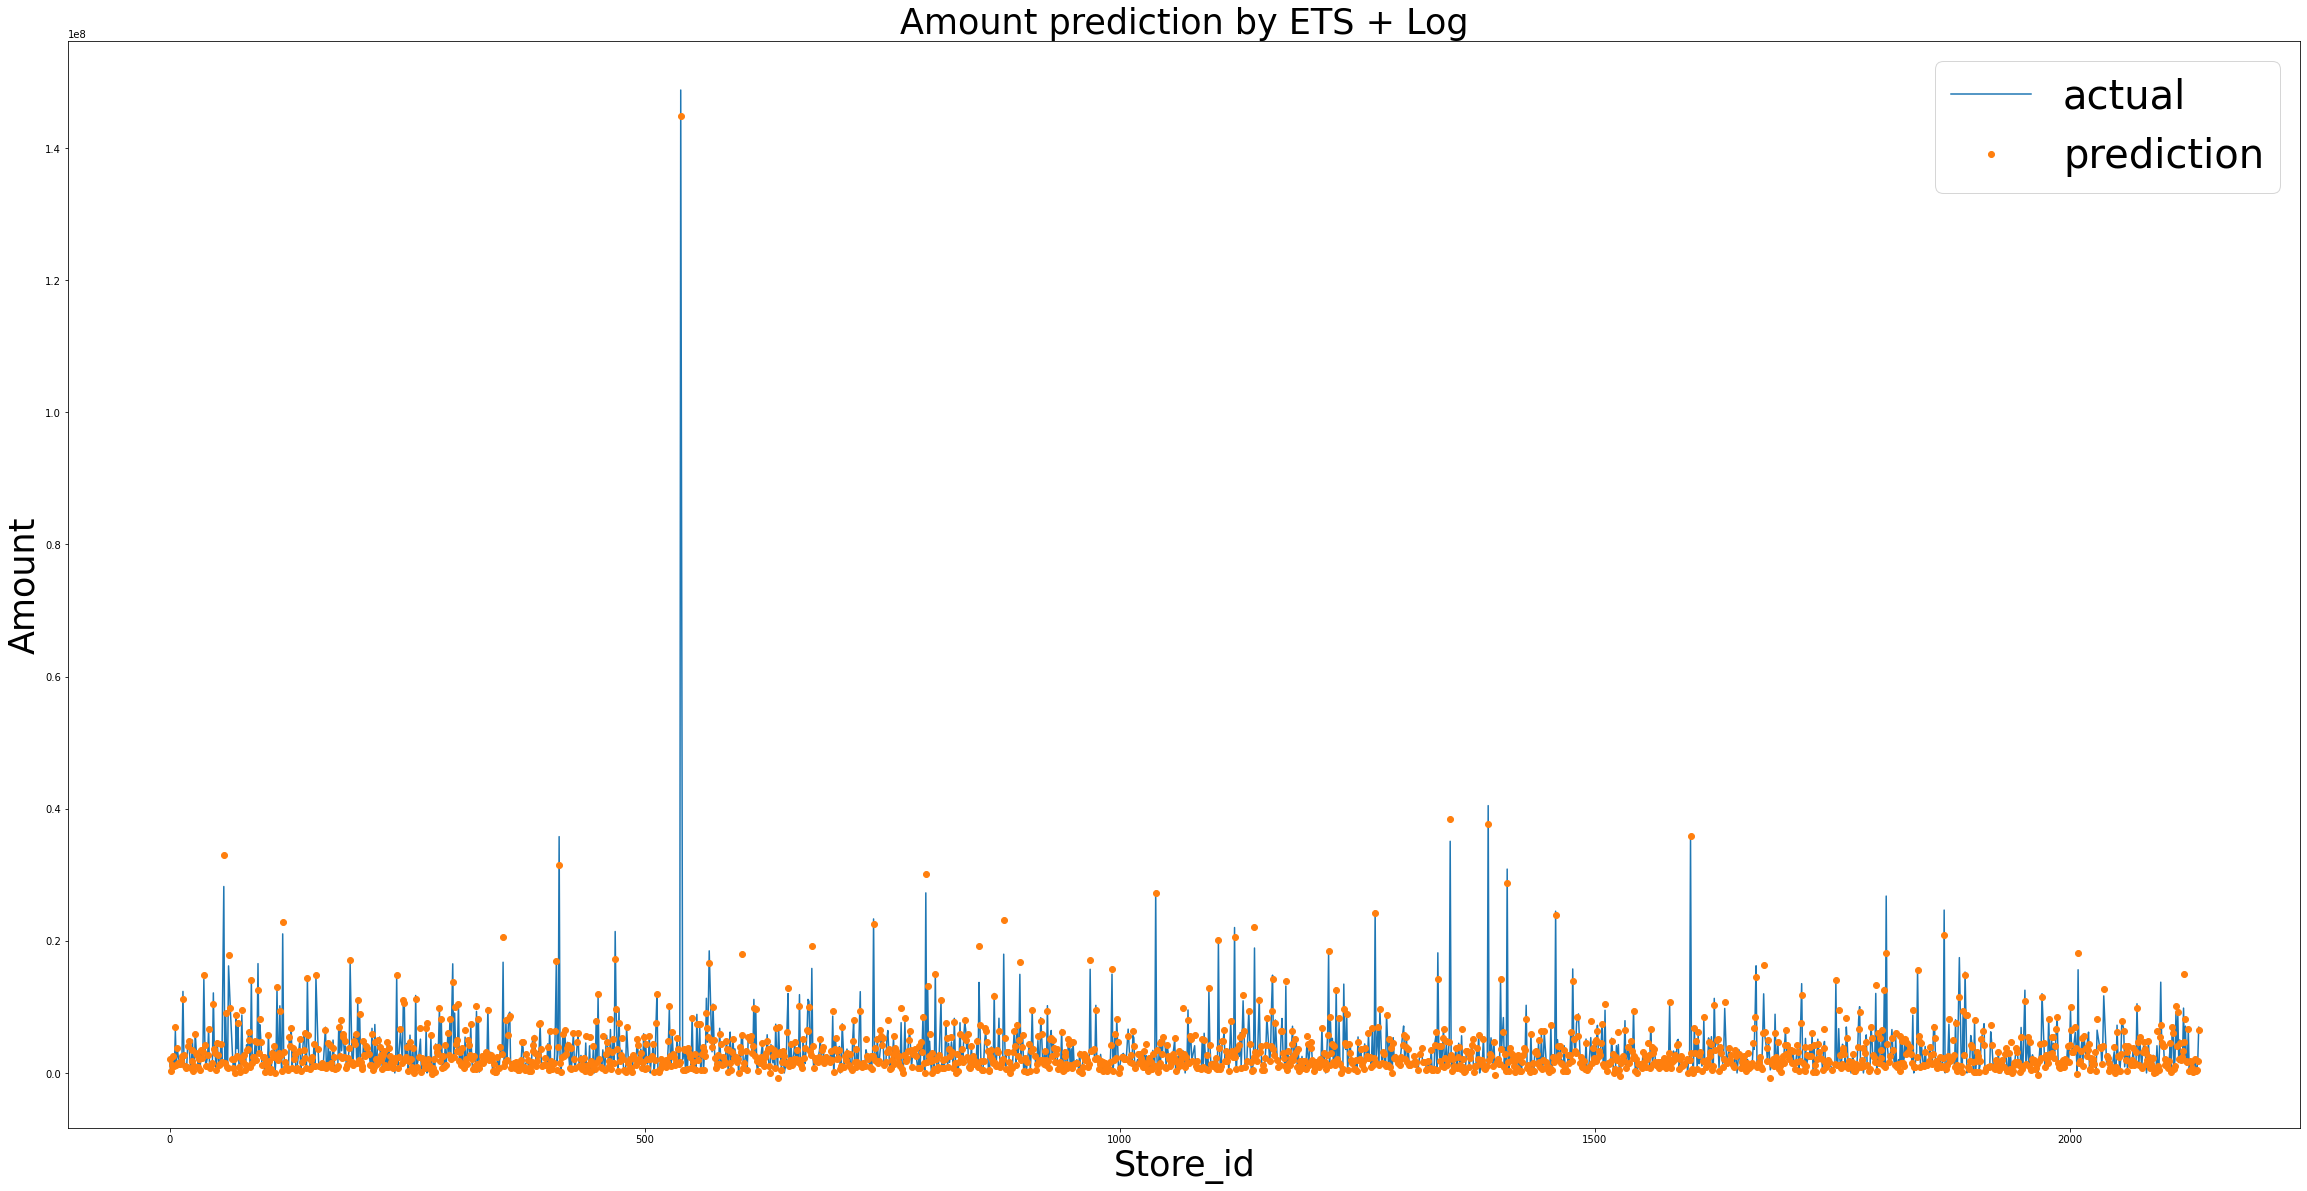

In [88]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,20))

x_values = list(resampling_data.store_id.unique())
y_values1 = list(df['test'].values)
y_values2 = list(df['pred'].values)

plt.plot(x_values, y_values1)
plt.plot(x_values, y_values2,'o')

plt.xlabel('Store_id', fontsize=35)
plt.ylabel('Amount', fontsize=35)
plt.title('Amount prediction by ETS + Log', fontsize=35)

plt.legend(['actual', 'prediction'], fontsize=40)

plt.show()

### 5-2. 파이썬에서 R 시계열 패키지 forecastHybrid를 통한 앙상블

#### 평균 앙상블
- ARIMA, 지수평활법, STL 분해를 적용한 지수평활법으로  
    3개의 예측치를 생성한 다음, 평균값을 구해 최종 매출액을 계산.
- 앙상블은 여러 모델을 결합해서 예측하는 것이므로, 과적합을 방지하는 효과가 있음
- 개별모델의 성능이 잘 안나올 때 앙상블을 이용하면 성능 향상을 이룰 수 있음
- R의 forecastHybrid 패키지를 통해 시계열 모델에 대한 앙상블 손쉽게 할 수 있음

In [89]:
import rpy2.robjects as robjects # r 함수를 파이썬에서 사용 가능하게 변환하는 모듈
from rpy2.robjects import pandas2ri # 파이썬 자료형과 R 자료형의 호환을 도와주는 모듈
import numpy as np

# pandas2ri를 활성화 
pandas2ri.activate()

# hybridModel 함수 정의 (Str형식 & r코드)
hybridModel = """
    function(ts){
        library(forecast)                                   # forecast 패키지 로드
        library(forecastHybrid)                             # forecastHybrid 패키지 로드
        d_params=ndiffs(ts)                                 # 시계열 자료의 차분 횟수 계산
        
        hb_mdl<-hybridModel(ts, models="aes",               # auto_arima, ets, stlm
                        a.arg=list(max.p=2, d=d_params),    # auto_arima parameter
                        weight="equal")                     # 가중치를 동일하게 줌(평균)
        forecasted_data<-forecast(hb_mdl, h=3)              # 이후 3개월(h=3)을 예측
        outdf<-data.frame(forecasted_data$mean)             # 예측값을 R의 데이터프레임으로 변환
        colnames(outdf)<-c('amount')                        # amount라는 열로 이름을 지정
        outdf                                               # 예측값 반환
    }
""" 

# r() 함수로 r 자료형을 파이썬에서 사용 가능
hybridModel = robjects.r(hybridModel)
ts = robjects.r('ts') # r 자료형 time series 자료형으로 만들어주는 함수
c = robjects.r('c') # r 자료형 벡터를 만들어주는 함수
log = robjects.r('log') # 로그 변환 함수
exp = robjects.r('exp')# 로그 역변환 함수

results = []

for i in tqdm(resampling_data.store_id.unique()):
    store = resampling_data[resampling_data['store_id']==i]
    
    # train, test 분리 (마지막 3개월분을 test 데이터로 사용)
    store = store[store.index <= len(store)-4]
    test = store[store.index > len(store)-4]
    
    start_year = int(min(store['year_month'])[:4]) # 영업 시작 년도
    start_month = int(min(store['year_month'])[5:]) # 영업 시작 월
    
    # 매출의 변동계수 구하는 함수 실행 (상점별)
    cv = coefficient_variation(resampling_data, i)
    
    # 매출액 변동 계수가 0.3 미만인 경우만 log를 씌움
    if cv < 0.3:
        # R의 ts 함수로 time series 데이터로 변환
        # 로그 정규화
        train_log = ts(log(store['amount']), start=c(start_year,start_month), frequency=12)
        
        # 앙상블 예측
        forecast_log = hybridModel(train_log)
        
        # 예측값을 로그 역변환해서 final_pred 리스트에 추가
        pred = np.sum(pandas2ri.ri2py(exp(forecast_log)).values)
        
    # 매출액 변동 계수가 0.3 이상인 경우
    else:
        # R의 ts 함수로 time series 데이터로 변환
        train = ts(store['amount'], start=c(start_year,start_month), frequency=12)
        
        # 앙상블 예측
        forecast = hybridModel(train)
        
        # ri2py를 사용하여 예측값의 형변환(R 데이터프레임 -> 파이썬) & 리스트에 추가
        pred = np.sum(pandas2ri.ri2py(forecast).values)
        
    # 예측 성능 평가
    test = np.sum(test['amount'])

    # MAE
    error = abs(test-pred)
    
    results.append({'test':test, 'pred':pred, 'error': error})

100%|██████████████████████████████████████████████████████████████████████████████| 1967/1967 [28:10<00:00,  1.16it/s]


In [90]:
from pandas import DataFrame
df = DataFrame (results,columns=['test','pred', 'error'])
df

,test,pred,error
0,2.066857e+06,2.064327e+06,2530.152170
1,2.393571e+05,2.468642e+05,7507.048905
2,1.176143e+06,9.895215e+05,186621.361340
3,2.409571e+06,2.490053e+06,80481.615968
4,9.032286e+05,1.032135e+06,128906.519921
...,...,...,...
1962,2.306143e+06,2.174122e+06,132020.397099
1963,5.876714e+05,3.908832e+05,196788.257195
1964,2.745000e+05,4.536155e+05,179115.498014
1965,1.949714e+06,1.725830e+06,223884.663665


In [91]:
df.describe()

,test,pred,error
count,1.967000e+03,1.967000e+03,1.967000e+03
mean,3.326176e+06,3.330254e+06,4.823343e+05
std,4.986604e+06,5.074075e+06,8.585131e+05
min,6.000000e+00,-9.226879e+05,1.300000e+01
25%,1.120643e+06,1.083228e+06,8.361112e+04
50%,2.138429e+06,2.161275e+06,2.240726e+05
75%,3.994286e+06,4.070541e+06,5.370262e+05
max,1.487844e+08,1.551586e+08,1.324072e+07


In [92]:
mae_ensemble = df['error'].mean()

In [93]:
mae_ensemble

482334.32516829425

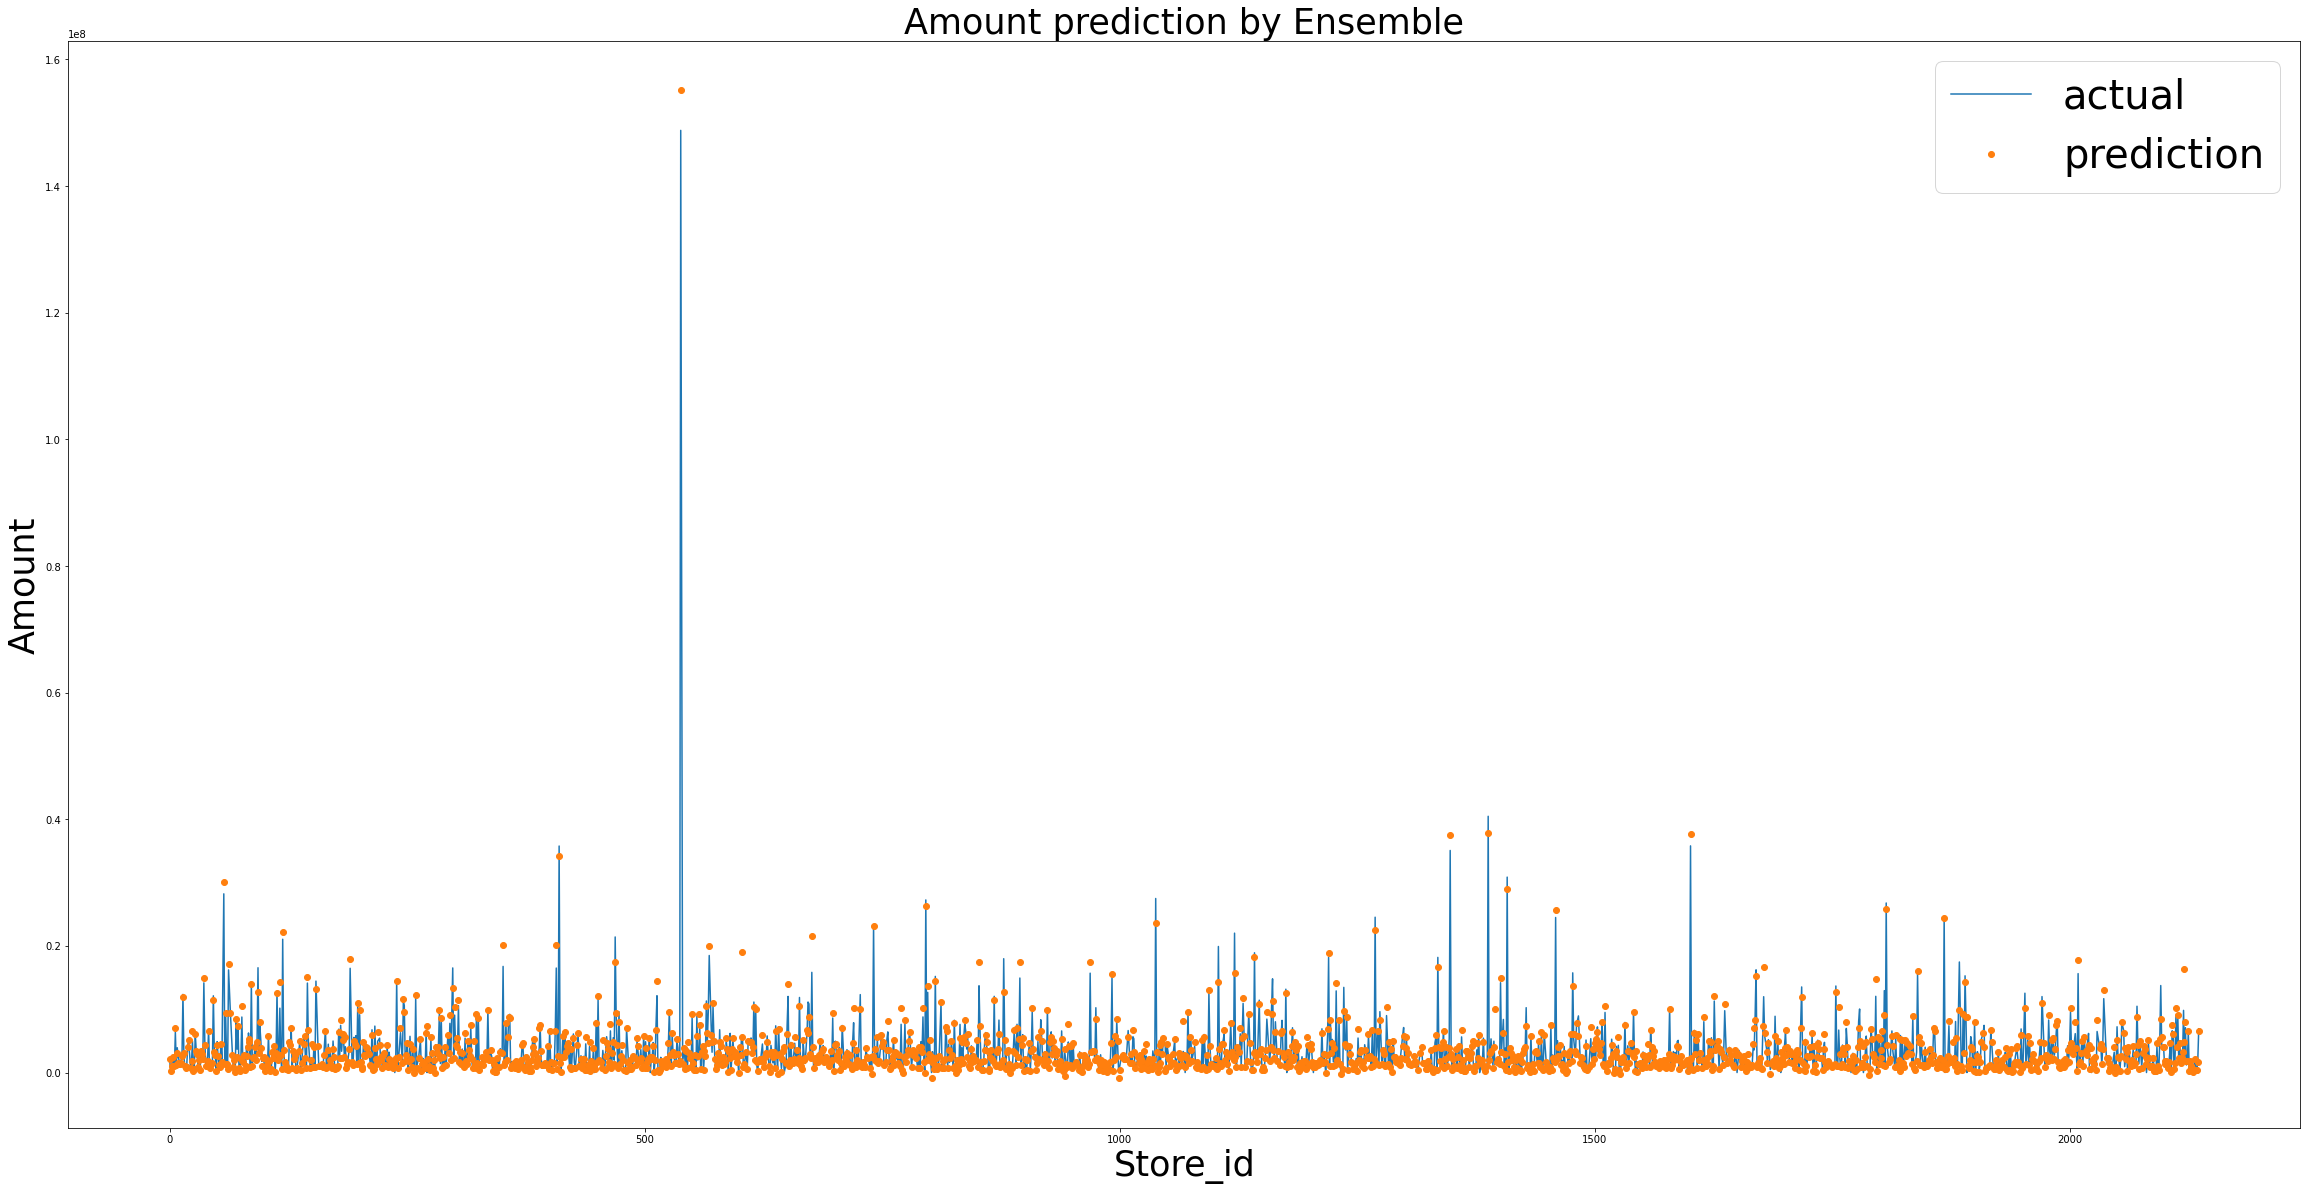

In [94]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(40,20))

x_values = list(resampling_data.store_id.unique())
y_values1 = list(df['test'].values)
y_values2 = list(df['pred'].values)

plt.plot(x_values, y_values1)
plt.plot(x_values, y_values2,'o')

plt.xlabel('Store_id', fontsize=35)
plt.ylabel('Amount', fontsize=35)
plt.title('Amount prediction by Ensemble', fontsize=35)

plt.legend(['actual', 'prediction'], fontsize=40)

plt.show()

#### hybridModel() 함수
- 첫번째 인자로 R의 time series 자료형을 받는다.
- models에 넘겨준 인자 aes는 앙상블 할 모델을 설정하는 인자로,  
    forecast에 있는 함수 auto.arima, ets, stlm의 앞글자를 따서 합쳐놓은 것
- ARIMA, 지수평활법, STL 분해를 적용한 지수평활법을 이용하여 앙상블을 진행할때에는 인자로 aes를 설정하면 됨.
- a.arg 인자는 atuo.arima의 파라미터를 설정하는 인자
- weight 인자에 'equal'을 넘겨주면 동일한 가중치로 예측을 진행함
- 로그 정규화는 변동 계수가 0.3 미만인 경우에 진행
- 최종 예측치를 hybridModel 함수를 사용하여 생성

데이콘 평가 결과

성능평가 순위 | 모델 | 리더보드 순위 | 점수
:--------:|:--------:|:--------:|:--------:|
1위 | **앙상블(aes)** |  | **741,880점**
2위 | 지수평활법 + 로그정규화 |  | 793,546점
3위 | 지수평활법 | 10위 | 794,263점
4위 | ARIMA | 18위 | 844,384점
5위 | STL분해 | 21위 | 869,178점

성능평가 순위 | 모델 | mae
:--------:|:--------:|:--------:|
1위 | **앙상블(aes)** | **18596.648280486465**
2위 | 지수평활법 + 로그정규화 | 18617.046400616877
3위 | ARIMA | 412885.71428571455
4위 | 지수평활법 | 53595.96760843415
5위 | STL분해 | 53595.96760843415  

In [97]:
final_mae = {'model': ['ARIMA', '지수평활법', 'STLM 분해', '로그정규화+지수평활법', '앙상블(aes)'], 
             'MAE': [mae_arima, mae_ets, mae_stlm, mae_log, mae_ensemble],
            '데이콘': [844384, 794263, 869178, 793546, 741880]}

final_result = pd.DataFrame(final_mae)
final_result = final_result.sort_values('MAE', ascending=True)
final_result

,model,MAE,데이콘
1,지수평활법,410417.052063,794263
3,로그정규화+지수평활법,417194.164517,793546
4,앙상블(aes),482334.325168,741880
0,ARIMA,596650.376919,844384
2,STLM 분해,656867.798586,869178


#### -> train data에서 3개월분을 test data로 나눠서 MAE 기준으로 모델을 평가 한 결과

In [98]:
final_mae = {'model': ['ARIMA', '지수평활법', 'STLM 분해', '로그정규화+지수평활법', '앙상블(aes)'], 
             'MAE': [mae_arima, mae_ets, mae_stlm, mae_log, mae_ensemble],
            '데이콘': [844384, 794263, 869178, 793546, 741880]}

final_result = pd.DataFrame(final_mae)
final_result = final_result.sort_values('데이콘', ascending=True)
final_result

,model,MAE,데이콘
4,앙상블(aes),482334.325168,741880
3,로그정규화+지수평활법,417194.164517,793546
1,지수평활법,410417.052063,794263
0,ARIMA,596650.376919,844384
2,STLM 분해,656867.798586,869178


#### -> 데이콘 리더보드 점수 기준으로 모델을 평가 한 결과